## A good title

This notebook includes the final results of the master thesis "XXX" by Martin Jacobson, 2021-05.

The structure is the following: 
1. Load datasets and visualize them in two dimensions. 
2. With ELM and KFoldCross validation showcase difference in MCC between them.
3. Get Feature importance form Extra Trees or Random Forest.
4. For each group of models on a set of datasets, Loop following steps. Grouping of model as; 
    (Multilayer Perceptron, ELM)
    (ELSVM, RUTSVM, CS-SVM)
    (Random Forests, Decision Tree, Bagging Decision Trees, Extra Trees)    
    2. Test PCA reduction, increasing one dimension at a time. 
    2. Adding one feature at at time, train top N models for each classifier and get new results.
    3. With a subset of features train models with sampling. Over-Under... etc..  
    4. Chaninging (train-test)-validation splits
    5. Showcase training times for models by using one dataset with increasing number of samples.     
    6. Train and optimize. Visualize Recall-Precision plot and MCC, with std.

Homebuilt functions can be viewed in 'funs.py'

In [1]:
'Import homebuilt functions'
from funs import *

'Import Classifiers'
from ELM import ELM 

'Import train test splits'
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
'Import plotting'
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
Datasets = {      
    'Standard':'no_agg_encoded',   # Jan-Feb
    'Aggregated 1':'agg0_encoded', # with frauds
    'Aggregated 2':'agg1_encoded', # with trans last 6,3,1m 
    'Aggregated 3':'agg2_encoded', # Periodic aggregated
    'Aggregated 4':'agg3_encoded', # Reciver, country, and bic specific no.trans, no.frauds..
    'Aggregated 1+2':'agg01_encoded',
    'Aggregated 1+2+4':'agg013_encoded',
    'Aggregated 1+2+3+4':'agg0123_encoded',    
#     'Dal Pozzolo Dataset':'DAL_P',
    'All trans':'SHB_3_wR_wE',     # All transactions Jan-Mar
    'Standard 2':'OneTypeTrans3_wR_wE', # Jan-Mar
}
folder = "/Users/Martin/Documents/Exjobb_Handelsbanken/Data"

## Visualize Datasets 

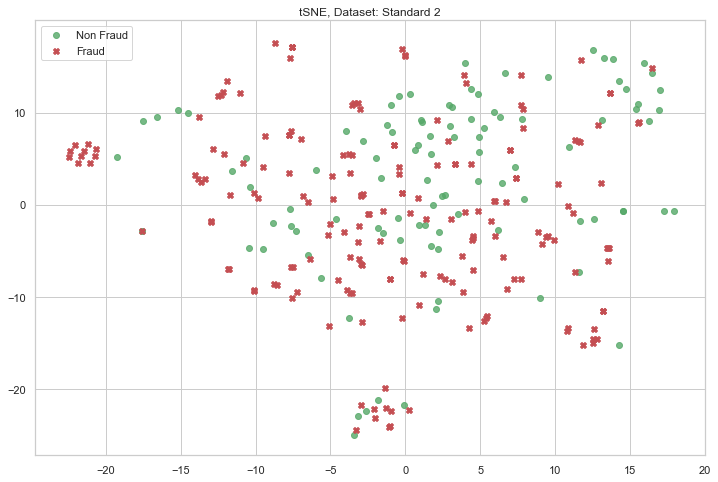

In [3]:
save_folder = 'Plots/visualize_datasets'
tempDataset = {'Standard':'no_agg_encoded'}

key = 'Standard 2'
for i in [1]:
# for i,key in enumerate(Datasets.keys()):
    df = read_data(Datasets[key],folder)
    mask = df['Class'] == 0
    n = min(100,mask[mask].shape[0]-1)
#     n = min(3000,mask[mask].shape[0]-1)
    
    non_fraud = df[mask].sample(n)
    fraud = df[~mask]
    df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

    X,Y = get_sets(df.copy())
    X,_ = scale_data(X,'Standard')    
    
    tsne_plot(X, Y, 
              save_name="{}/{}.png".format(save_folder,key),
              title='tSNE, Dataset: {}'.format(key),
              save=True, show=True, verbose=False,
              alpha_F=1, alpha_G=0.8,
              marker_F='X', marker_G='o'
              )

## Feature Importance

Correlation plots first.

Difference between my Datasets and Pozzolo's is that his is already gone through a PCA transformation.

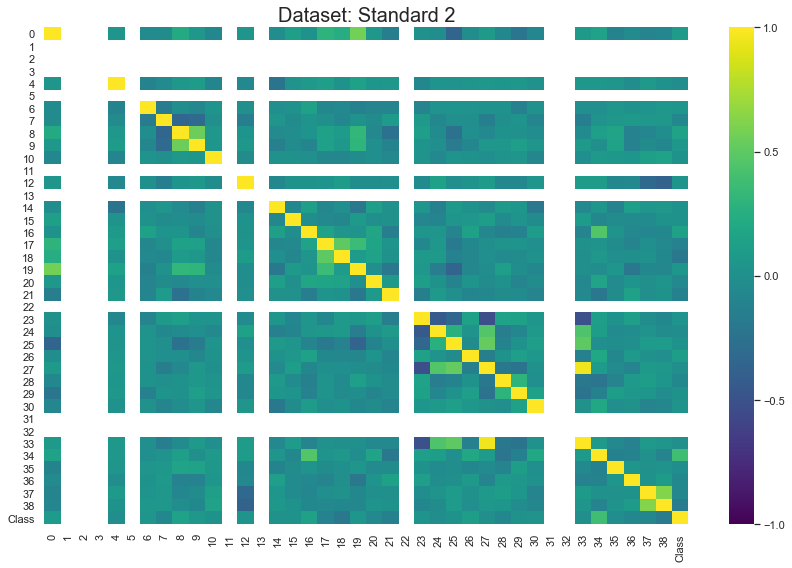

In [4]:
save_folder = 'Plots/Correlation'
key = 'Standard 2'
for i in [1]:
# for i,key in enumerate(Datasets.keys()):
#     df = read_data(Datasets[key],folder)
    f = plt.figure(figsize=(12, 8))
      
    corr = df.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
               vmin=-1,
               vmax=1,
               cmap='viridis',
               center=0,
               cbar_kws={"ticks":[-1,-.5,0,.5,1]},
               )
    plt.title('Dataset: {}'.format(key),fontdict ={'fontsize':20})
    plt.tight_layout()
    plt.savefig('{}/{}.png'.format(save_folder,key))
    plt.show()

Create a dictionary for each dataset which will store needed information.

In [5]:
set_dict = {}
for key in Datasets.keys():
    set_dict[key] = {}
    set_dict[key]['filename'] = Datasets[key]

Feature Importance scores.
We are training one model one the WHOLE dataset. This is because it is very important to not lose any information for each feature. A subset could over-/under-estimate each feature and would make the decision to remove features less prudent.

We train two identical Random Forest models with different split criterion; 'gini' and 'entropy'. Afterwards, since each criterion yields results within the same range, we average the measures to determine the 'True' importance order. We do not expect to gain to much by averaging. Bad features will rank low for both, but a bad feature might be super bad for one but not as much by the other.


In [6]:
save_folder = 'Plots/Feature Importance'
# key = 'Standard 2'
# for i in [1]:
for i,key in enumerate(Datasets.keys()):
    print(key)
    df = read_data(Datasets[key],folder)
    Y = df.pop('Class')
    evaluator= ['Extra','Decision','Random']
    evaluator = 'Random'
    
    fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=False,sharey=True)
    plt.tight_layout()
    col_order,importance = evaluate_features(df,Y,
                                             n_estimators=10,
                                             n_jobs=2,
                                             evaluator=evaluator,
                                            criterion='gini')
    col_order2,importance2 = evaluate_features(df,Y,
                                               n_estimators=10,
                                            n_jobs=2,
                                            evaluator=evaluator,
                                            criterion='entropy')
    
    temp = plot_feature_importance(col_order,importance,
                               sort=True,
                               ascending=False,
                               show=False,
                               ax= ax[0],
                            title_fontsize=10,
                            x_fontsize=10,
                            y_fontsize=10,
                            x_tick_size=10,
                            y_tick_size=10,
                               title='Dataset: {}, Evaluator: {}'.format(key,evaluator));    
    temp = plot_feature_importance(col_order2,importance2,
                               sort=True,
                               ascending=False,
                               show=False,
                               ax= ax[1],
                            title_fontsize=10,
                                x_fontsize=20,
                            y_fontsize=10,
                            x_tick_size=10,
                            y_tick_size=10,
                               title='Dataset: {}, Evaluator: {}'.format(key,evaluator));
    title='Dataset: {}, Evaluator: {}'.format(key,evaluator)
    ax[1].set_ylabel('')
    ax[0].set_ylabel('')
    ax[0].set_xlabel('')
    ax[0].title.set_text('Gini Scores')
    ax[1].title.set_text('Entropy Scores')
    fig.text(-0.05, 0.5, 'Importance weights',size=20, va='center', rotation='vertical')
    fig.text(0.3, 1.05, title,size=20)#, va='left')
    
#     fig.savefig('{}/{}.png'.format(save_folder,key+'_gini_entorpy'), bbox_inches = "tight");
#     plt.close()
    
    order_df = pd.DataFrame()
    order_df.loc[:,'index'] = df.columns[col_order]
    order_df.set_index('index',inplace=True,drop=True)

    
    cols1 = df.columns[col_order]
    cols2 = df.columns[col_order2]
    order_df.loc[cols1,'Gini'] = importance
    order_df.loc[cols2,'Entropy'] = importance2
    
    order_df.sort_values('index',inplace=True)
    order_df.loc[:,'Average'] =  (order_df.loc[:,'Gini'] + order_df.loc[:,'Entropy']) / 2 
    order_df.sort_values('Average',inplace=True,ascending=False)

    col_order = order_df.index
    importance = order_df.loc[:,'Average'].values
    
    set_dict[key]['Features'] = {}
    set_dict[key]['Features']['Avg. Importance Scores'] = importance
    set_dict[key]['Features']['Importance Order'] = col_order
    
    fig0,ax = plot_feature_importance(col_order,importance,
                                sort=True,
                                ascending=False,
                                show=False,
                                title_fontsize=20,
                                x_fontsize=20,
                                y_fontsize=20,
                                x_tick_size=20,
                                y_tick_size=20,
                                title='Average Scores, Dataset: {}, Evaluator: {}'.format(key,evaluator));
#     fig0.savefig('{}/{}.png'.format(save_folder,key))
    plt.close('all')

Standard
Aggregated 1
Aggregated 2
Aggregated 3
Aggregated 4
Aggregated 1+2
Aggregated 1+2+4
Aggregated 1+2+3+4
All trans
Standard 2


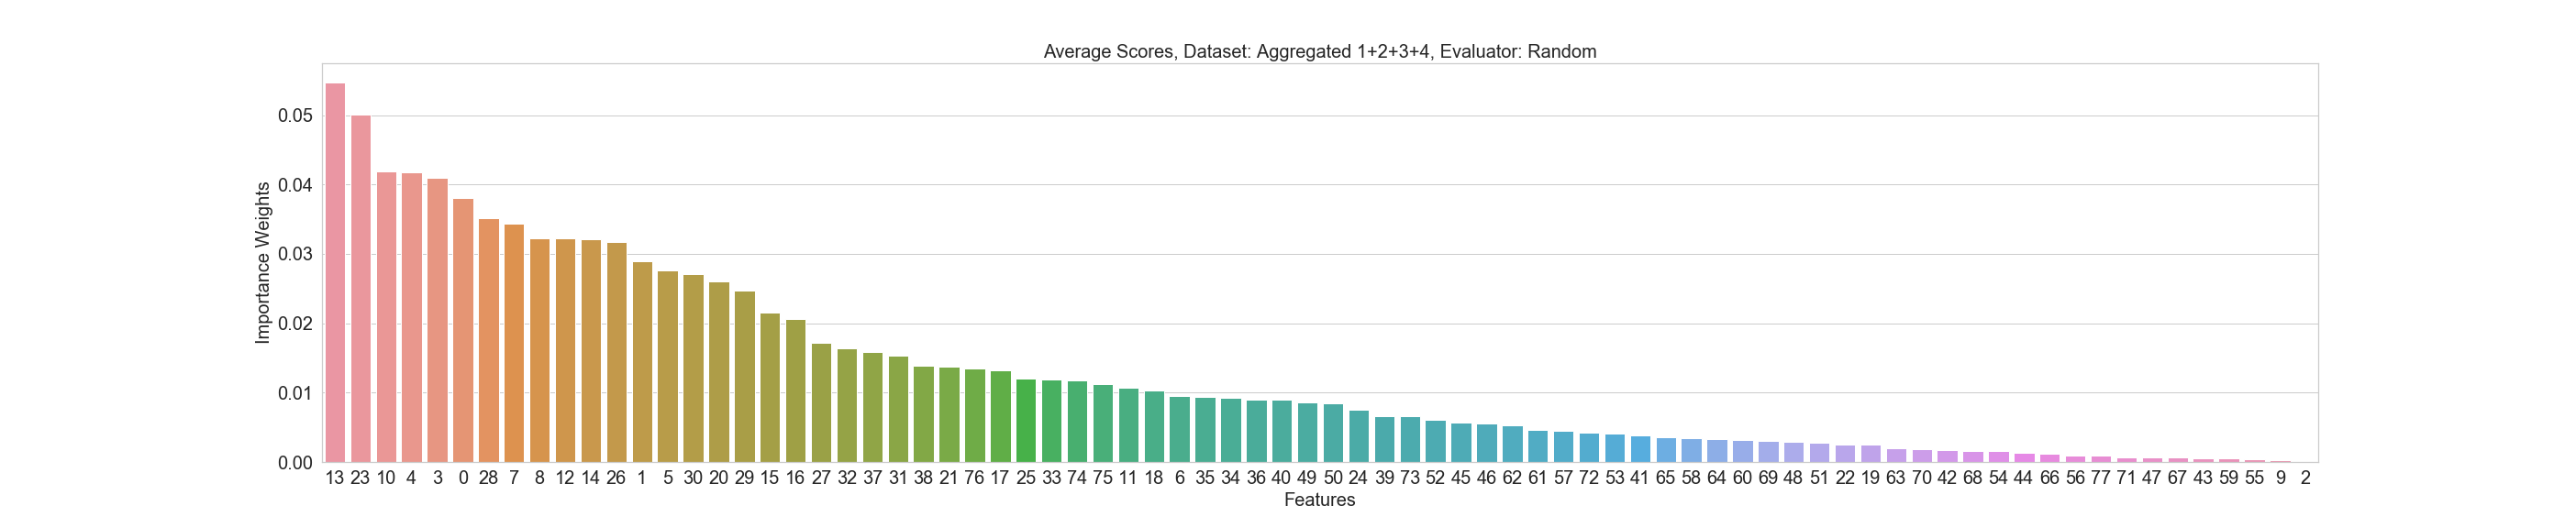

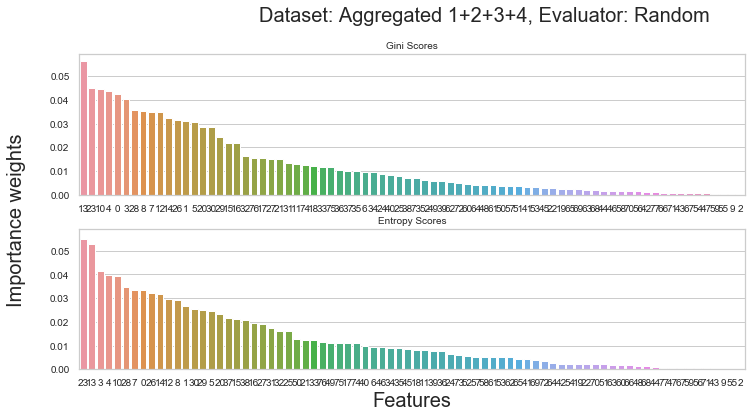

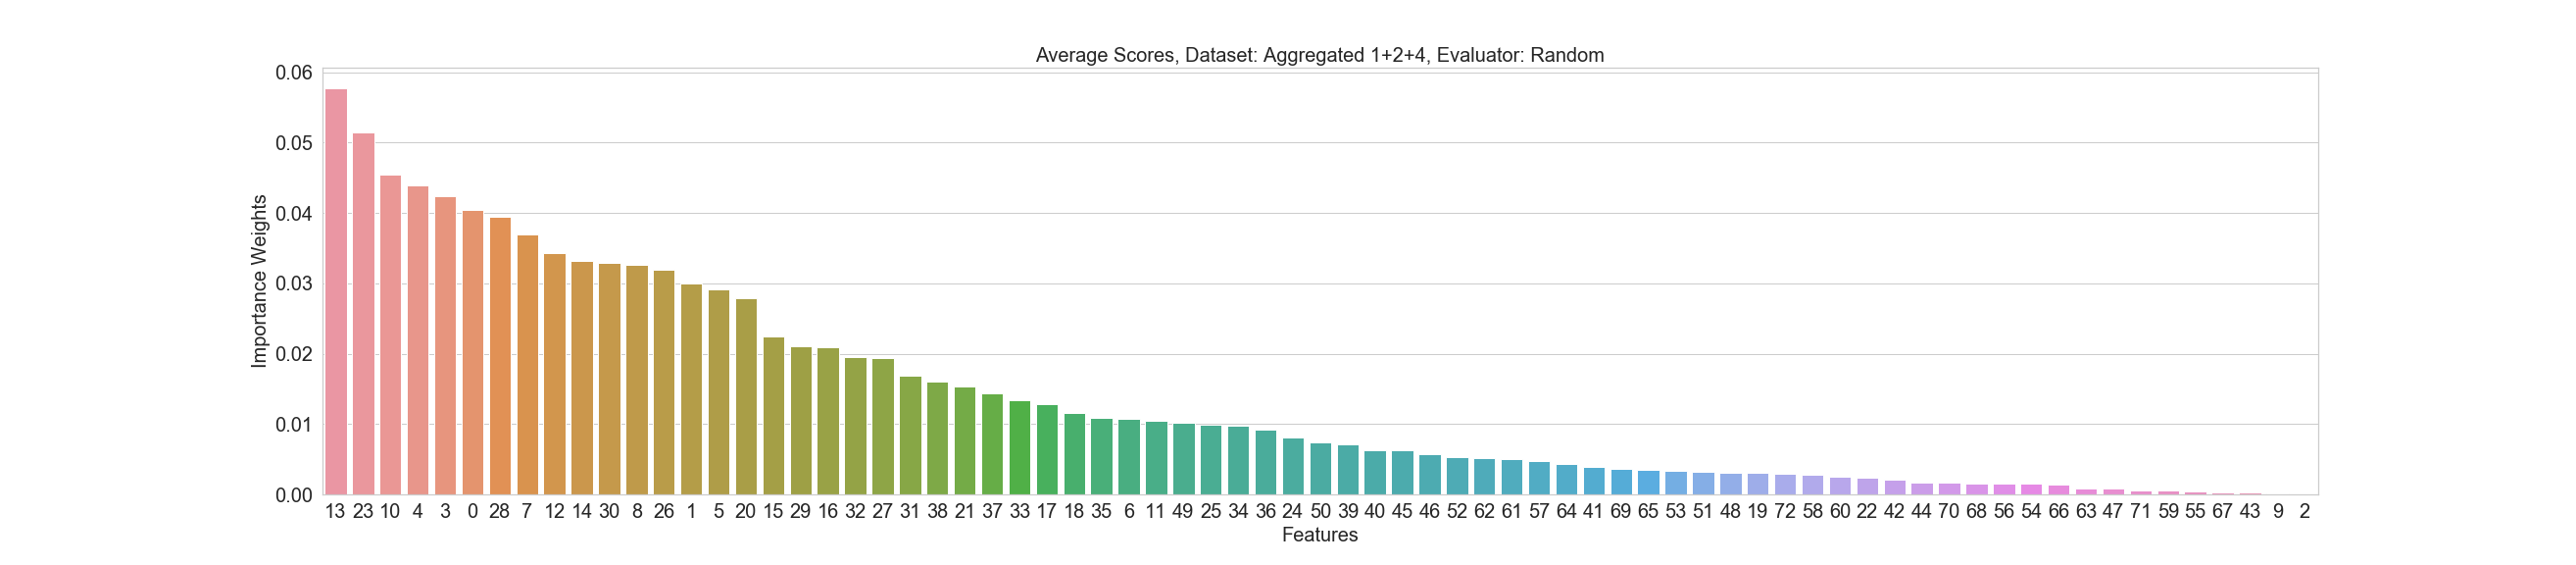

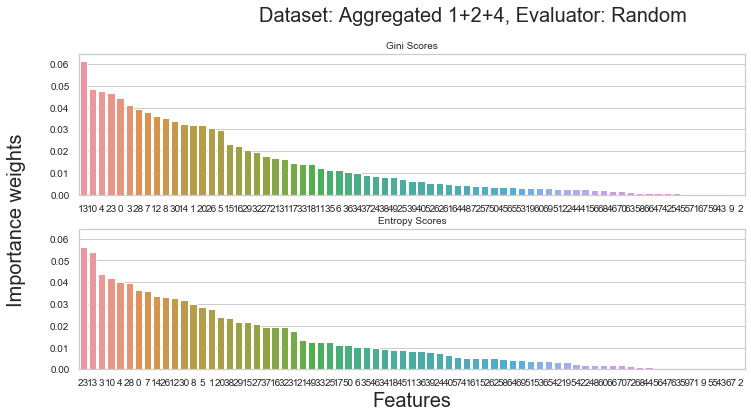

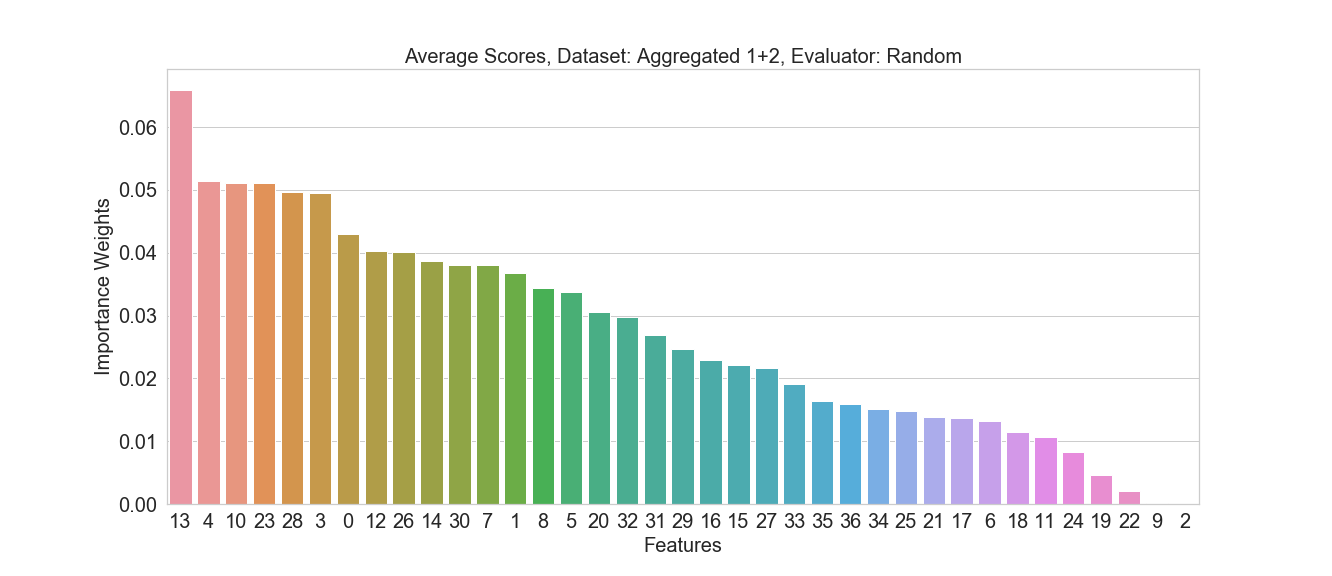

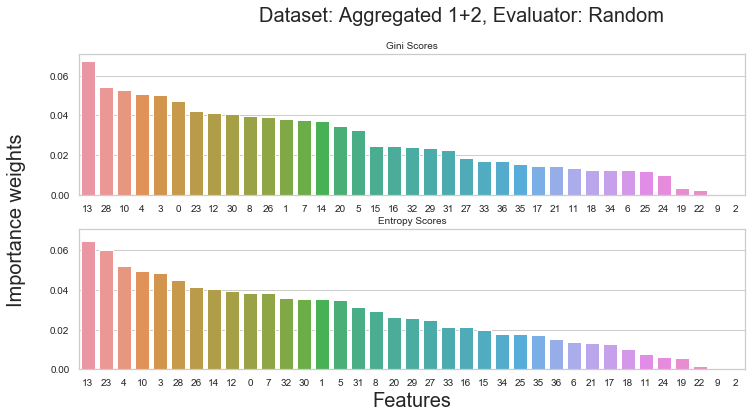

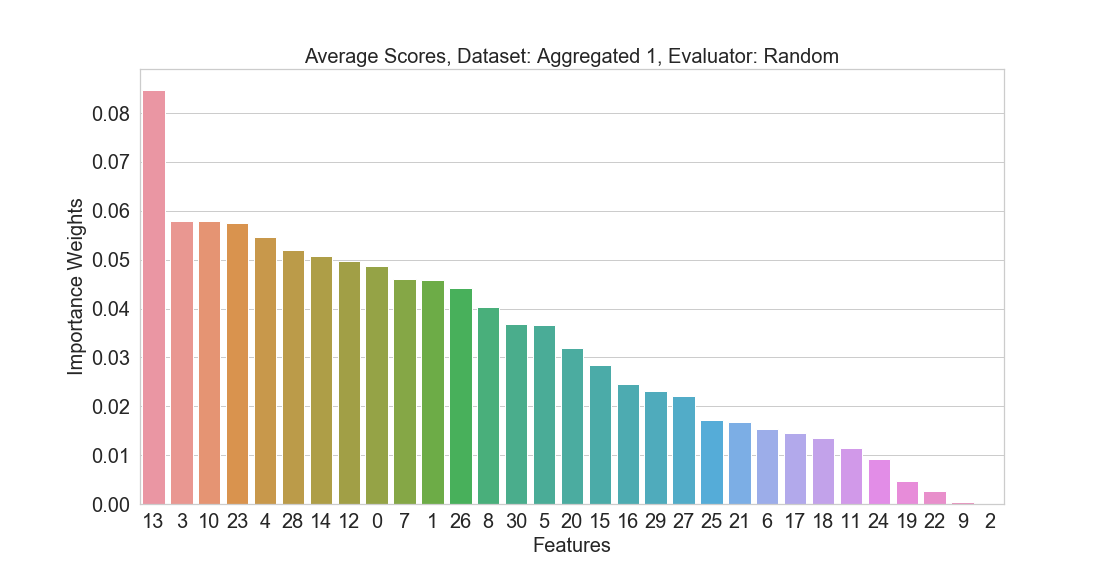

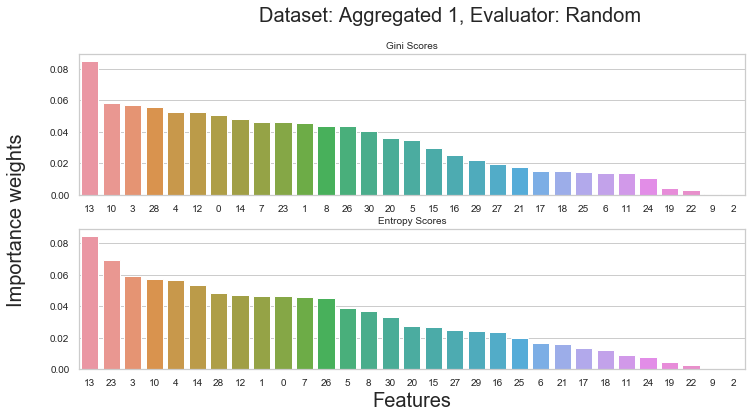

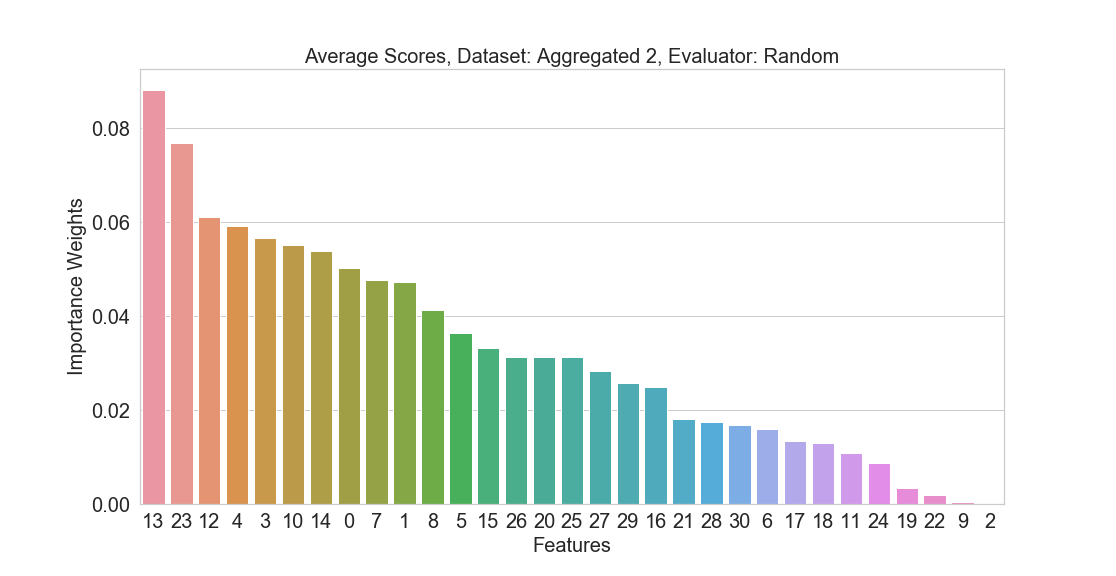

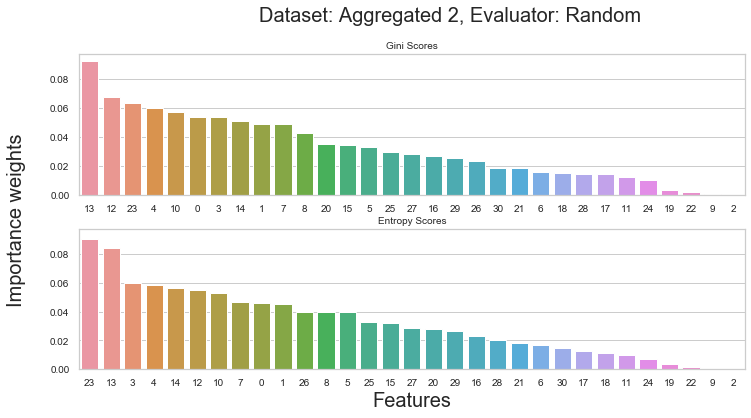

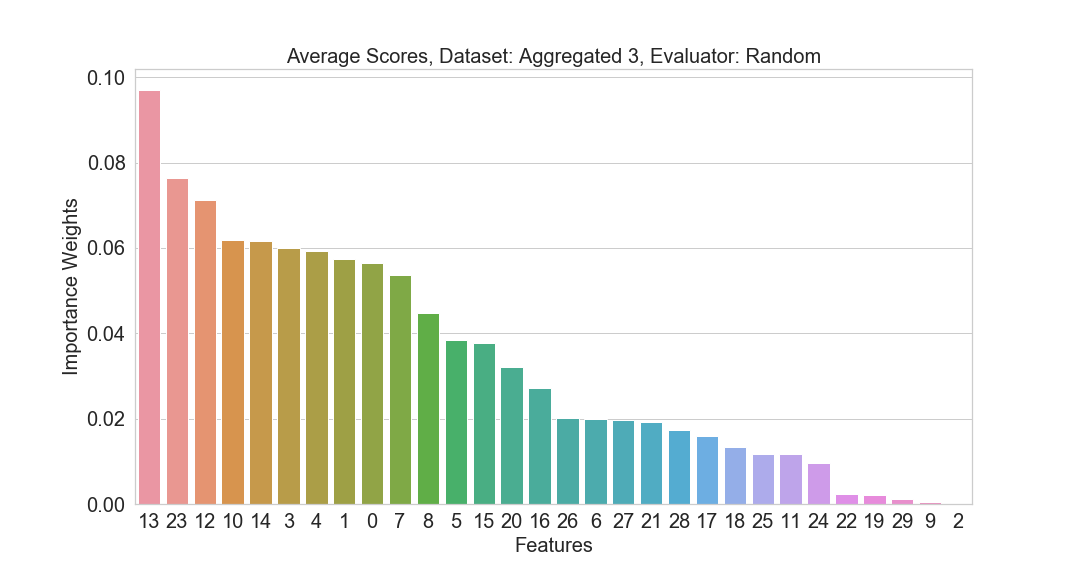

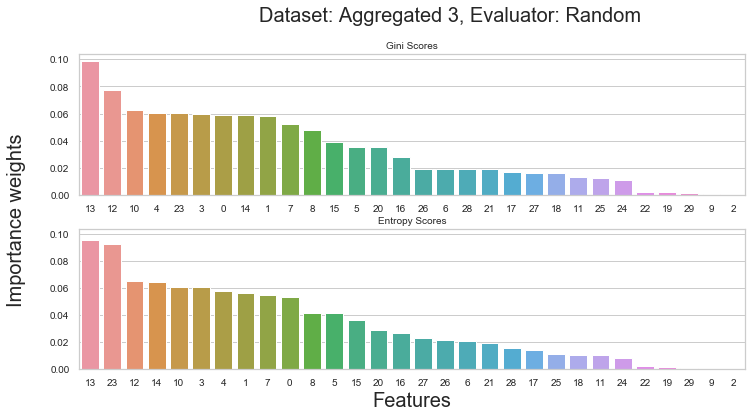

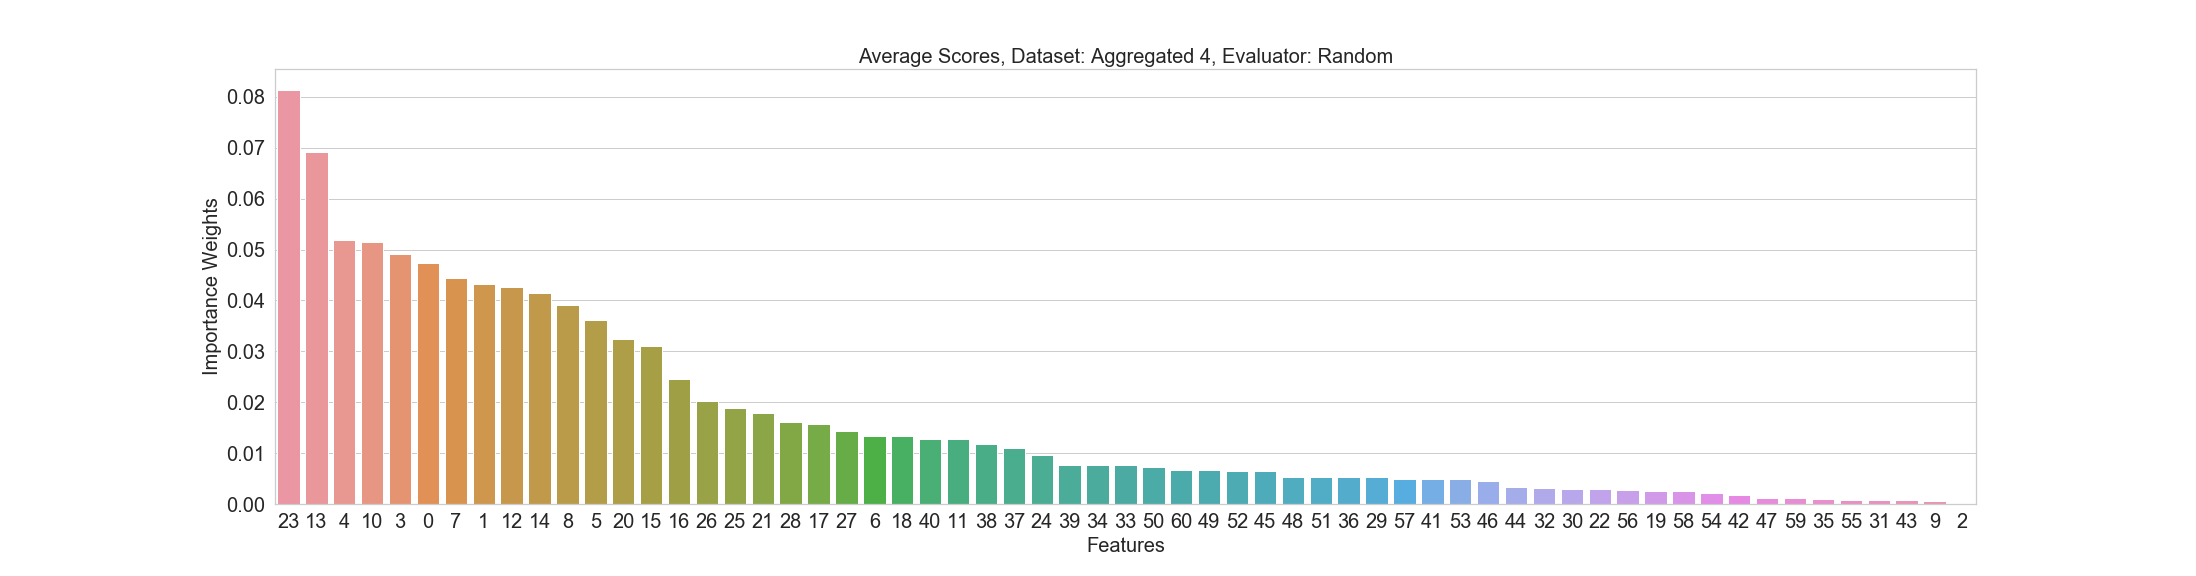

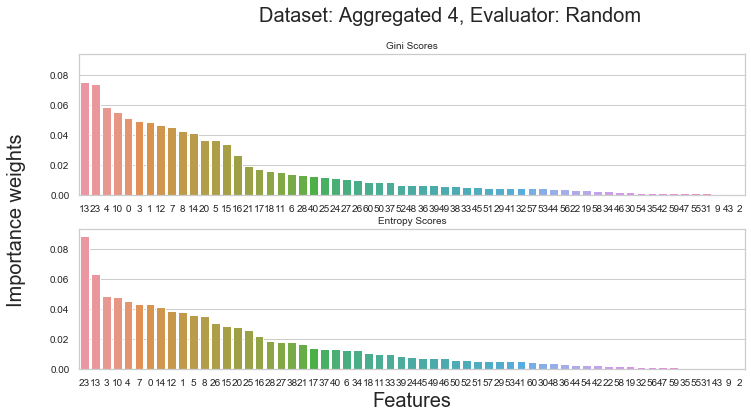

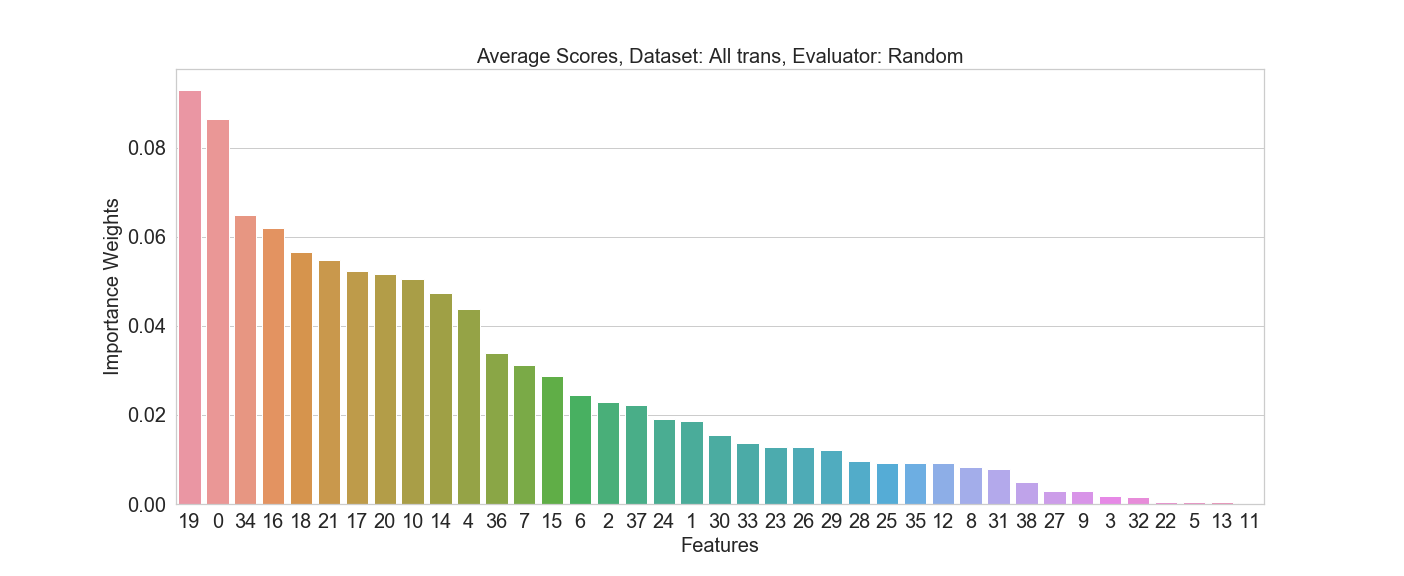

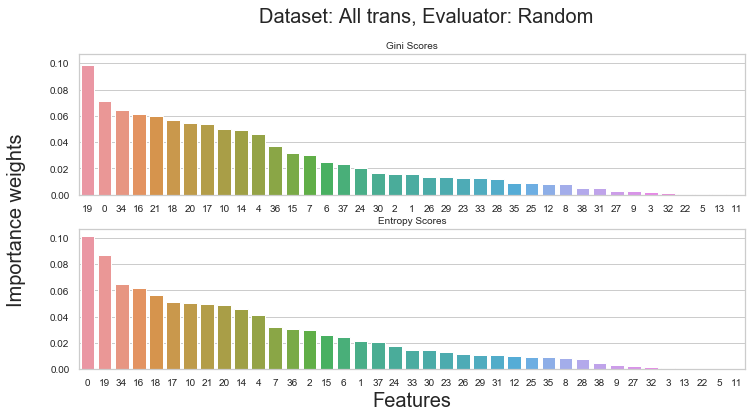

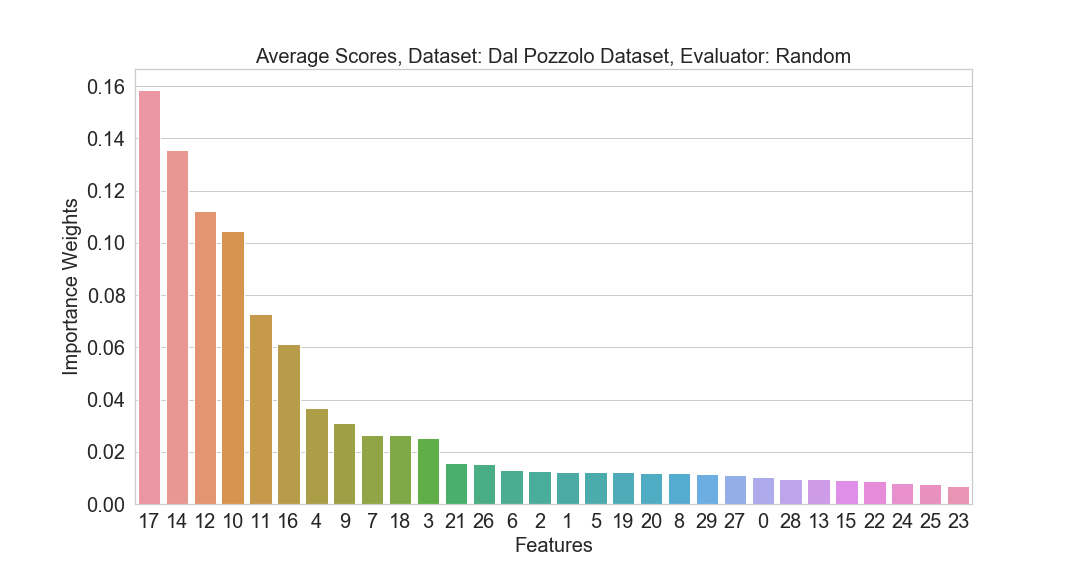

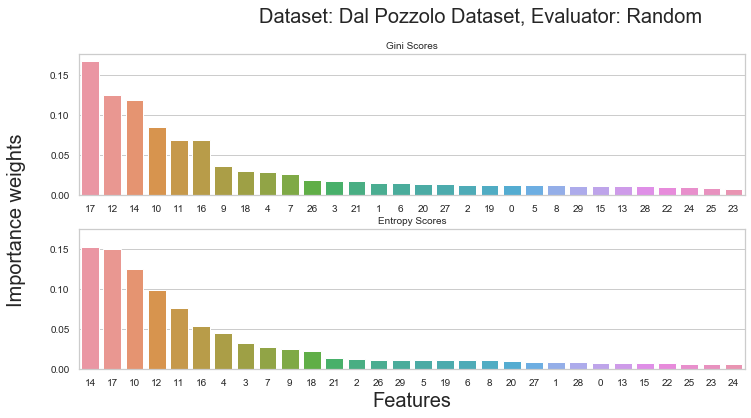

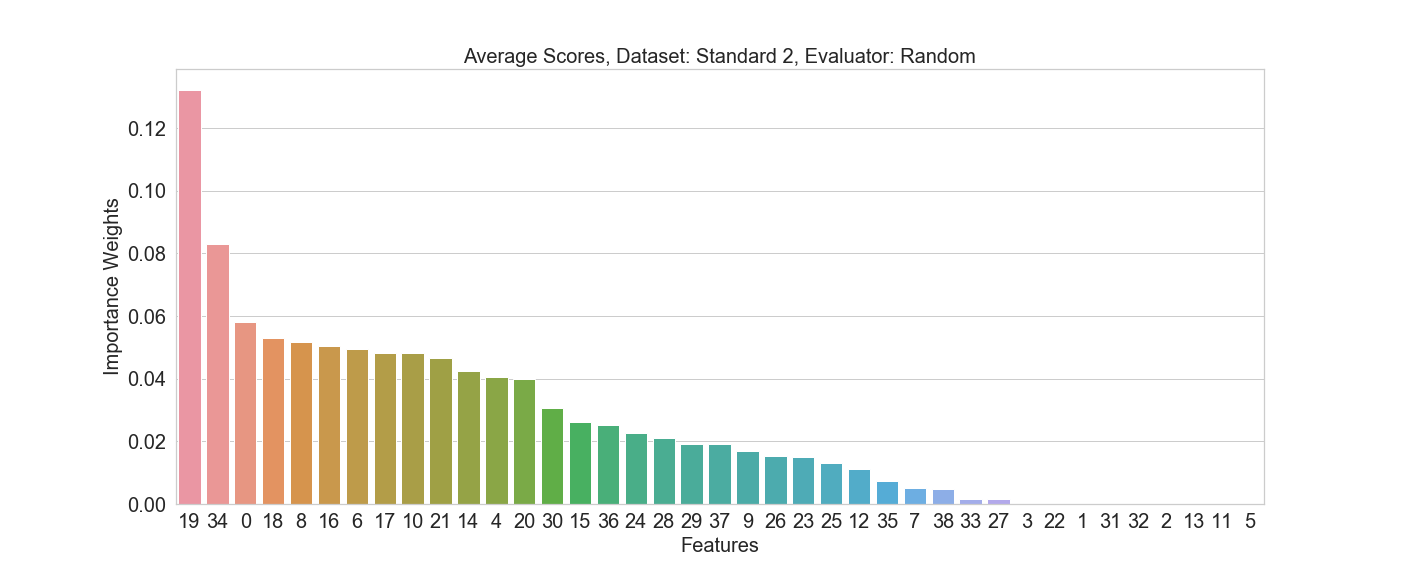

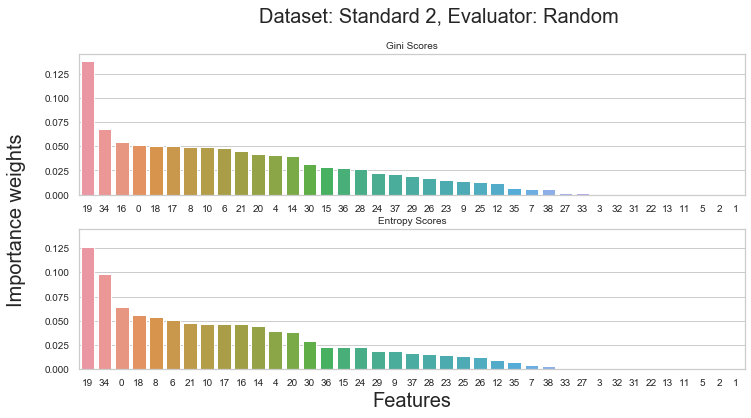

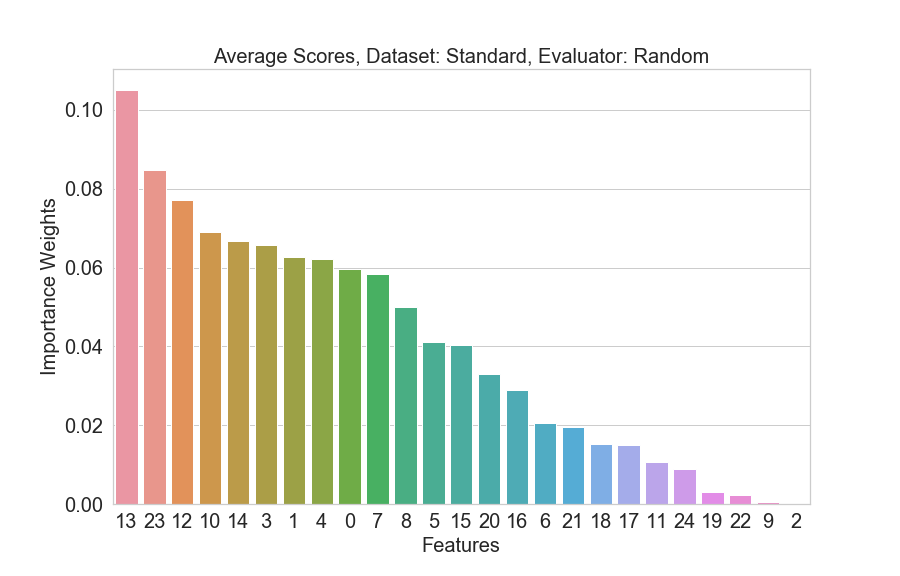

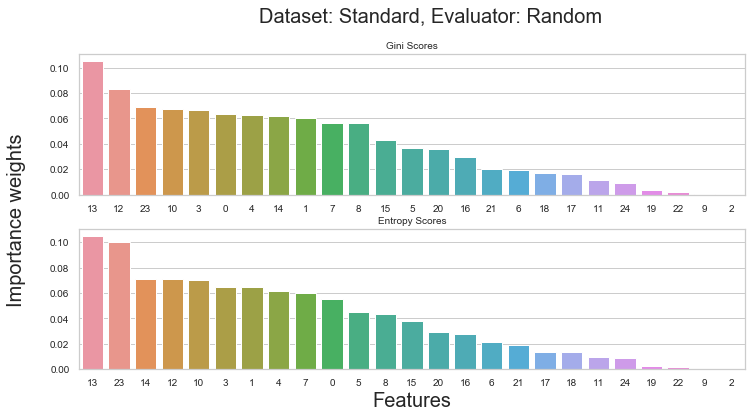

In [7]:
from IPython.display import Image, display
from os import listdir
from os.path import isfile, join

view_folder = '/Users/Martin/Documents/Exjobb final/Plots/Feature Importance/'
onlyfiles = [f for f in listdir(view_folder) if isfile(join(view_folder, f))]

for filename in onlyfiles:
    display(Image(filename=view_folder+'/{}'.format(filename)))

In [12]:
def run_feature_experiment(local_dict,key2, 
                          min_features = 10,
                          max_features = 45,
                          jump = 3,
                          scale = True,
                          do_PCA = False, # Cannot combine feature subset with do_PCA..
                          new_key = False,
                          feature_subset = False, 
                          SAMPLER_dict = {},
                          verbose = 1                       
                          ):
#     for i in [1]:
    for key in local_dict.keys():
        print(key)
        if new_key:
            local_dict[key][key2] = {}
        local_dict[key][key2]['Runs'] = {}
        local_dict[key][key2]['Runs']['Scores'] = {}
        local_dict[key][key2]['Runs']['All runs'] = {}
        
        filename = Datasets[key]
#         filename = local_dict[key]['filename']
        
        DF = read_data(filename,folder)

        Y = DF.pop('Class')    
        DF.loc[:,DF.dtypes == 'bool'] = DF.loc[:,DF.dtypes == 'bool'].astype(int)
    
        if feature_subset:            
            col_order = local_dict[key]['Features']['Importance Order'].values            
        
        no_feats=list(range(min_features,min(max_features,DF.shape[1]-1),jump))
#         no_feats=list(range(min(min_features,DF.shape[1],min(max_features,DF.shape[1]+1),jump)))
        for i,n_features in enumerate(no_feats):
            df = DF.copy()
            if verbose > 0:
                print('{}/{}'.format(i+1,len(no_feats)))
            
            if feature_subset:
                df = df.loc[:,col_order[0:n_features]]
            
            Xtrain,Xtest,Ytrain,Ytest = sets = train_test_split(df,Y.values,
                            train_size=0.5,
                            shuffle=False)
            
            Xtrain = Xtrain.values
            if scale:
                Xtrain,scaler = scale_data(Xtrain,'MinMax')
                Xtest= scaler.transform(Xtest.values)
                Xtrain = Xtrain.values
            if do_PCA:
                pca = PCA(n_components= n_features)
                Xtrain = pca.fit_transform(Xtrain)
                Xtest  = pca.transform(Xtest)
                
            if SAMPLER_dict:
                print('yoyo')
                sampler = SAMPLER_dict['sampler']
                sampling_strategy = SAMPLER_dict['strategy']
                sampler(sampling_strategy=sampling_strategy)
                Xtrain,Ytrain = sampler.fit_resample(Xtrain,Ytrain)

            if verbose >2:
                print(Xtrain.shape)
            mets = 0
            score_df = pd.DataFrame()
            for j in range(10):
                elm = ELM(m=128,w=10)#,type='wc') # 'standard 2'
                elm.fit(Xtrain,Ytrain)
                Ypreds = elm.predict(Xtest)
                met = getMetrics(Ytest,Ypreds)
                mets += met

                met.loc['Run'] = j+1
                score_df = score_df.append(met,ignore_index=True)

            if verbose > 2:
                print(mets/(j+1))
            local_dict[key][key2]['Runs']['Scores'][n_features] = mets / (j+1)
            local_dict[key][key2]['Runs']['All runs'][n_features] = score_df
    return local_dict

set_dict = run_feature_experiment(set_dict,'Features',
                                 feature_subset=True,
                                 scale=True,
                                 do_PCA = False,
                                 min_features = 1,
                                 max_features = 3,
                                 jump=1)
set_dict = run_feature_experiment(set_dict,'PCA reduction',do_PCA = True,new_key=True)

Standard
1/2
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance 

2/2
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Aggregated 1+2
1/2
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
C

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Covariance matrix is not

In [13]:
def box_plot_4_dict(key2 = 'Features',x_col='No. PCA components',xlabel=None,save=True,folder='Plots'):
    if xlabel is None:
        xlabel = x_col        
    for key in set_dict.keys():
        bigg_df = pd.DataFrame()
        for i in set_dict[key][key2]['Runs']['All runs'].keys():
            set_dict[key][key2]['Runs']['All runs'][i].loc[:,x_col] = i
            bigg_df =pd.concat([bigg_df,set_dict[key][key2]['Runs']['All runs'][i]]).reset_index(drop=True)        
        set_dict[key][key2]['All runs DF'] = bigg_df
#         plt.tight_layout();
        fig,ax= plot_boxchart(bigg_df,title=key,x=x_col,xlabel=xlabel);
        if save: 
            fig.savefig('{}/{}_{}.png'.format(folder,key,x_col))
            #     fig0.savefig('{}/{}.png'.format(save_folder,key))

Investigating features and adding the best available feature may not produce an optimal feature set, though this is and should be seen as a good indicator of which features are actually good and (if) when the number of features starts to become a problem. A good generalization for all sets can not with good conscience be made. Rule of tumb's can be stated for each set, even these may not be good practice, due to overfitting or losing pivital data for specific cases.

The Extreme Learning Machine classifier have a huge variance, which in our case is good. Even if for some subset of features the estimator is more likely to overfit, the ELM will produce bad results. Which means that overfittness will be visiable mostly as; a higher score with a very narrow 0.15 to 25 percentile span, see 'Aggregated 1' with 14 No. Features. On the contrary a narrow band of 75 to 99.85 percentile .

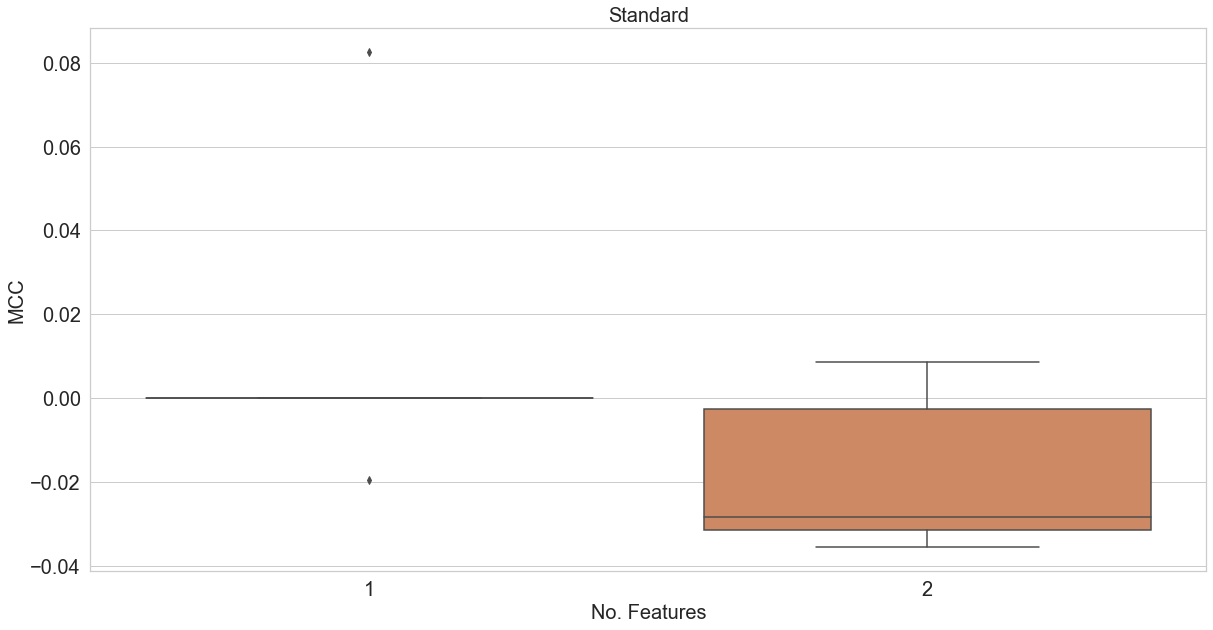

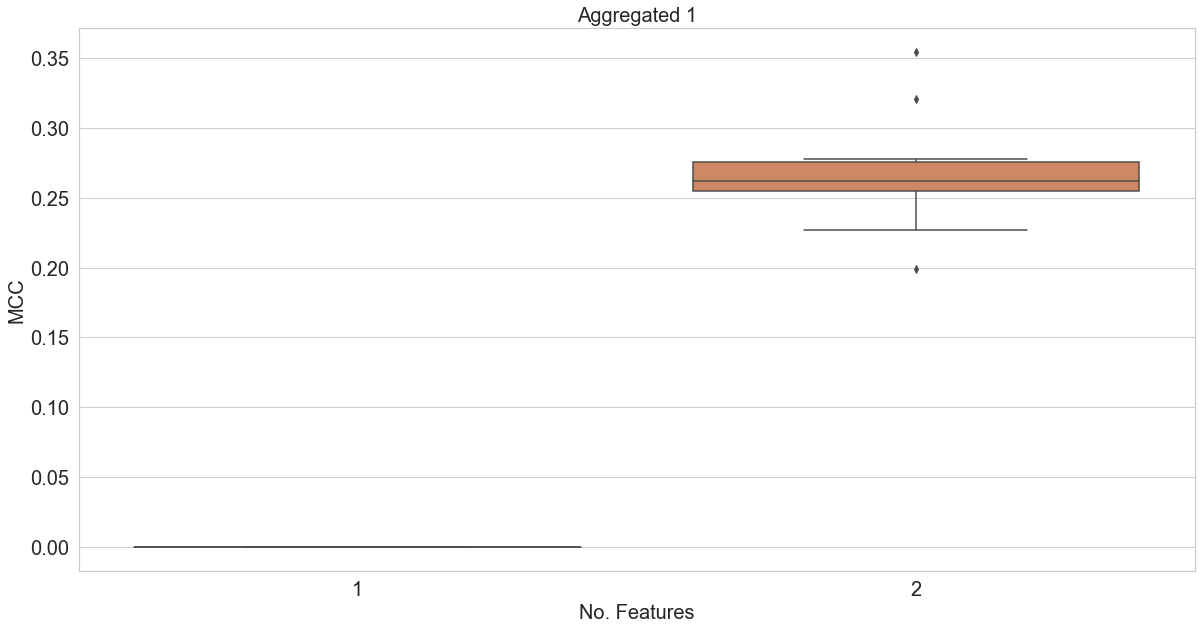

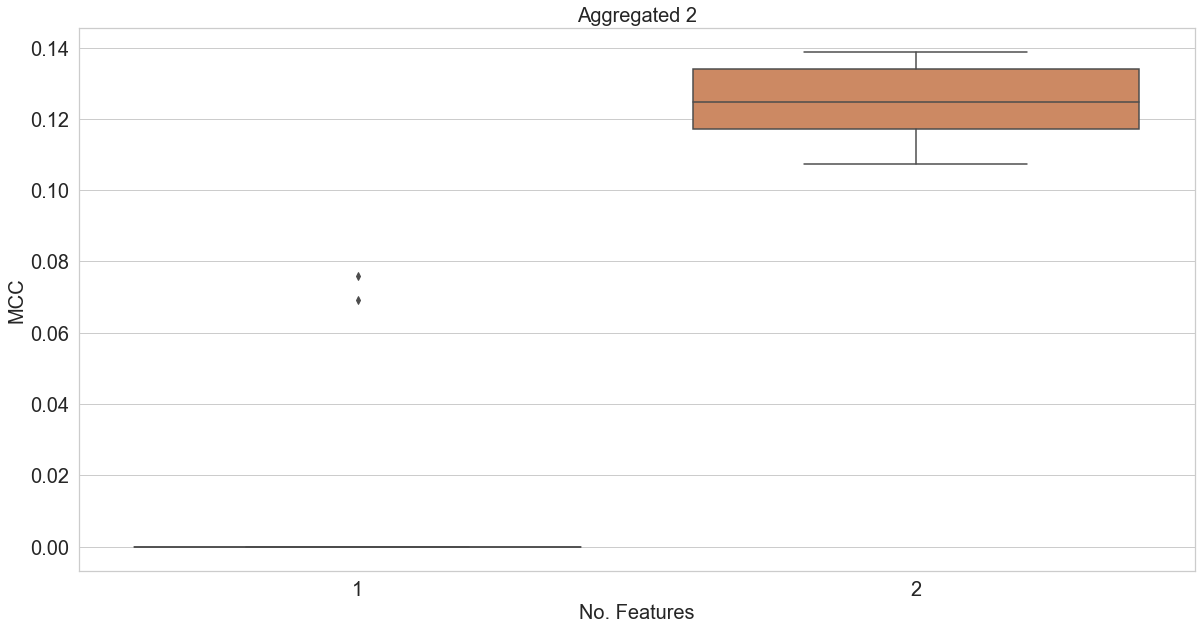

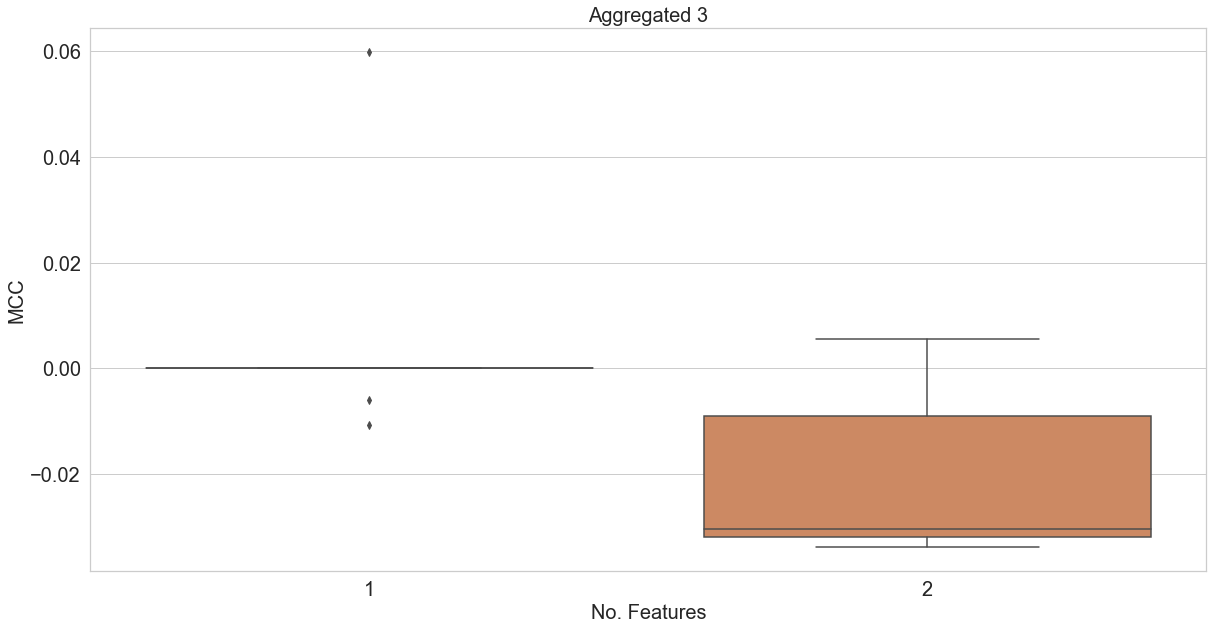

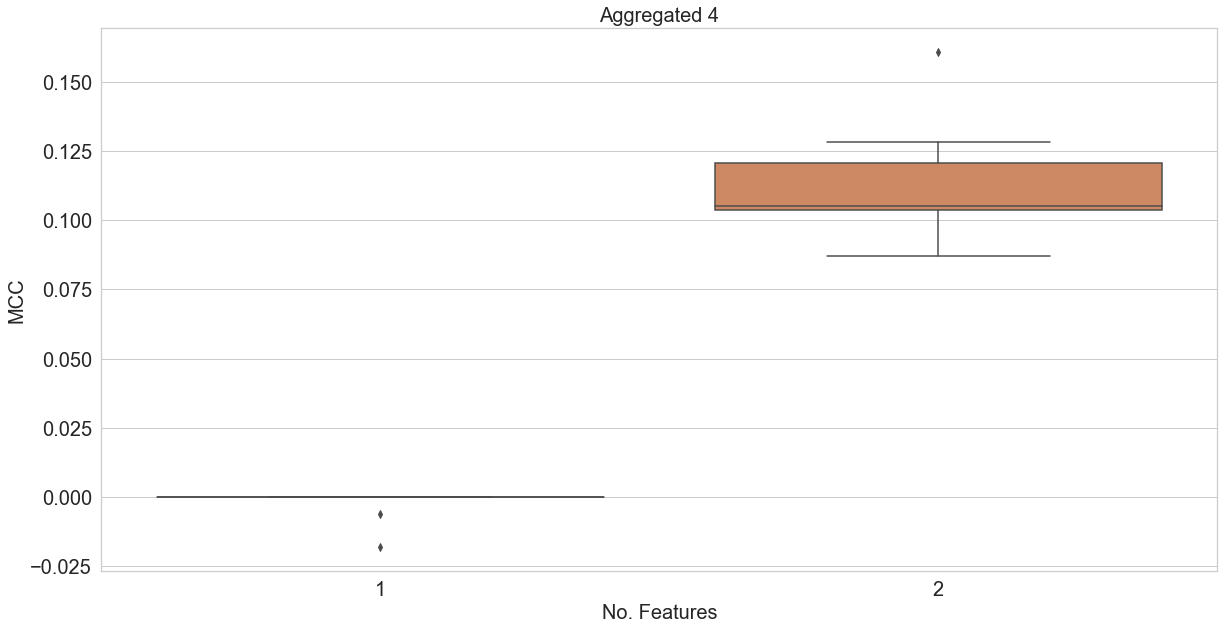

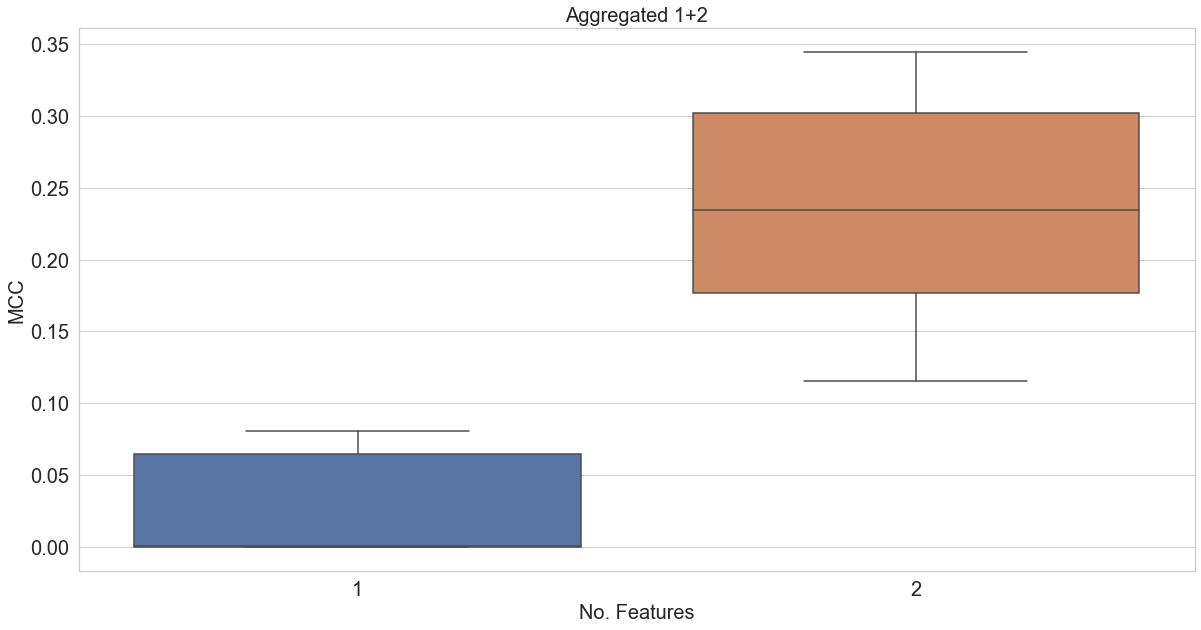

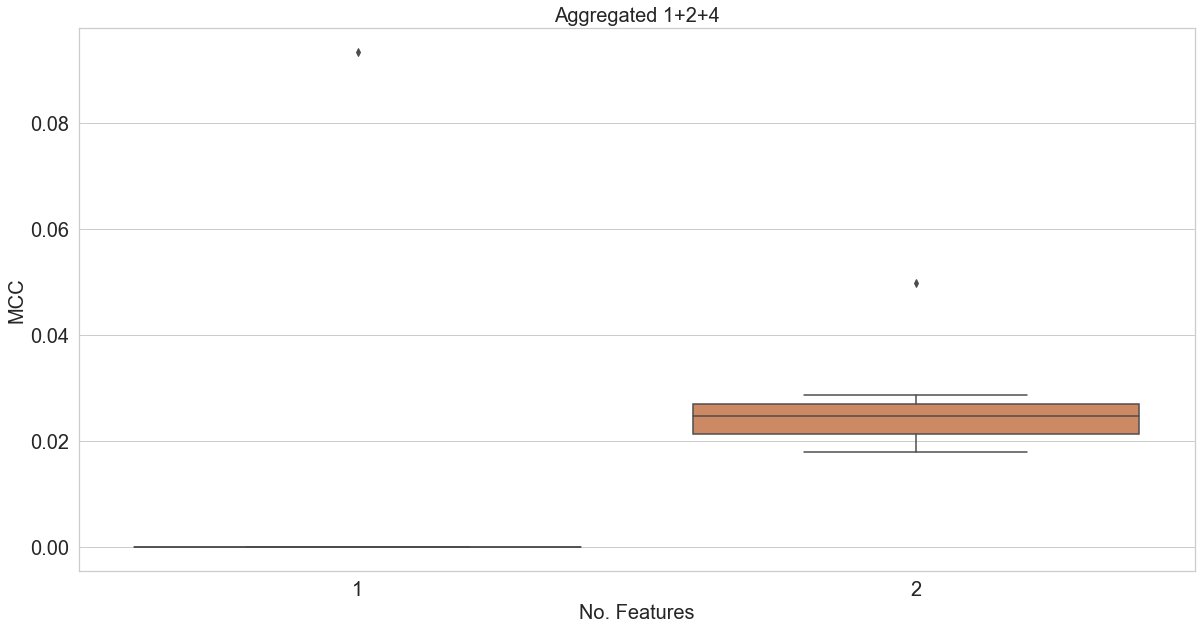

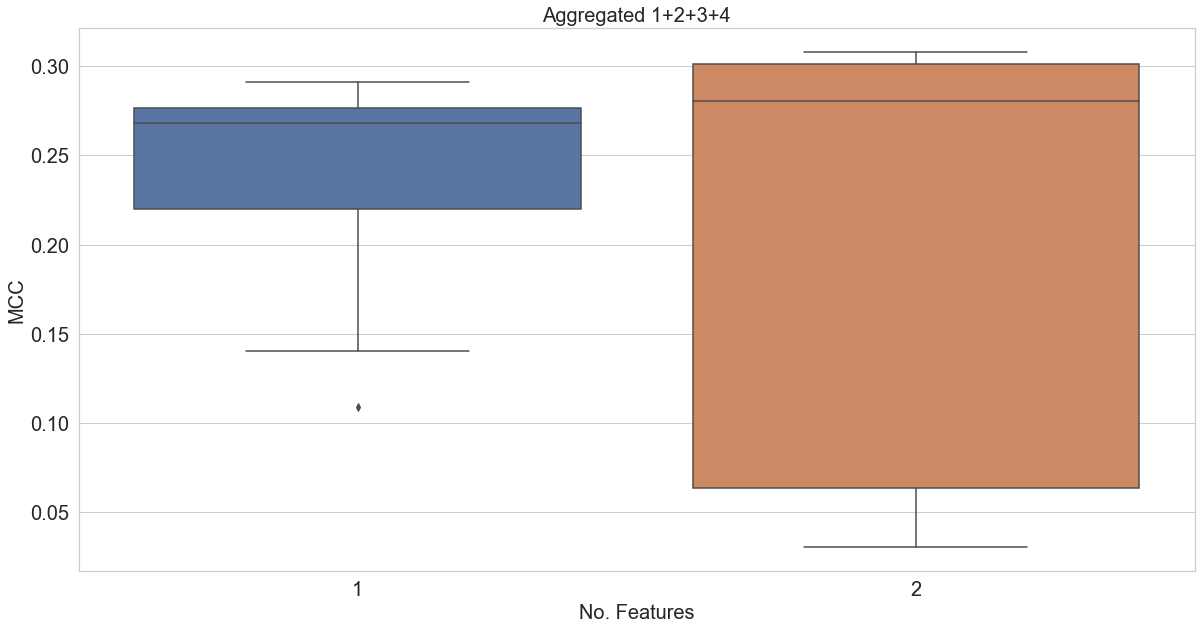

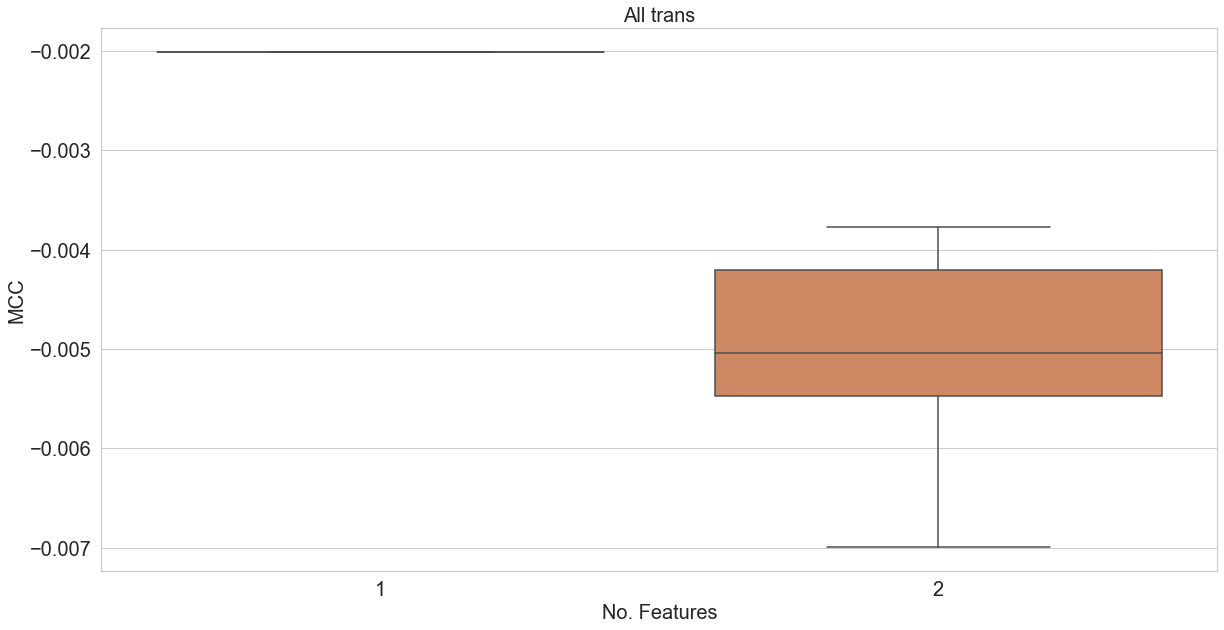

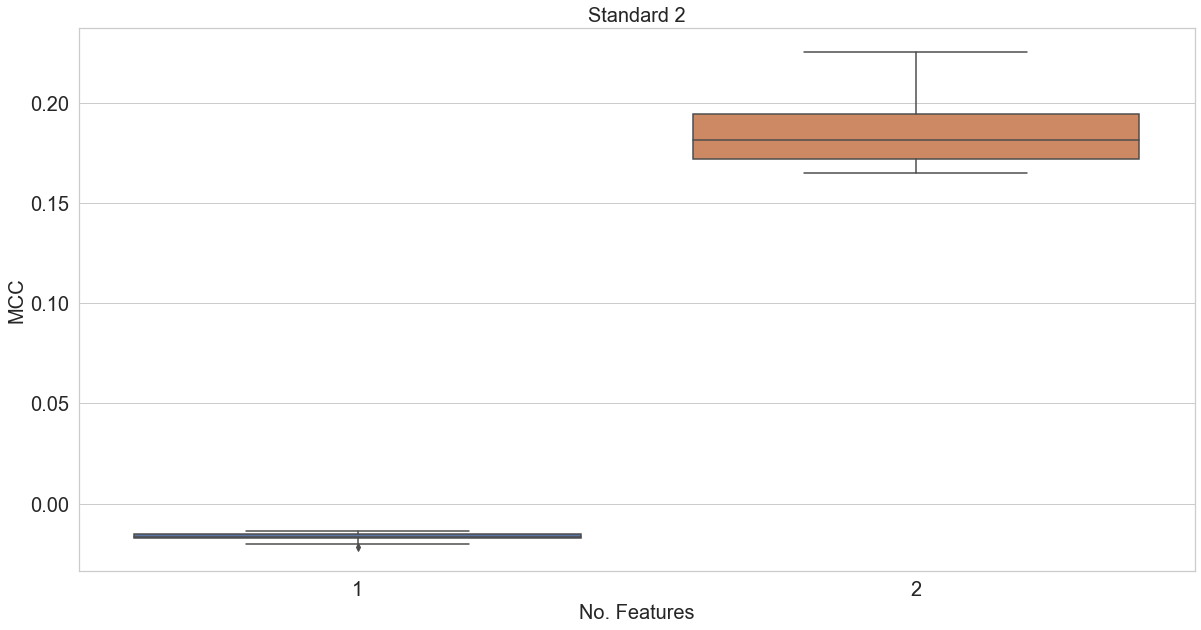

In [16]:
'Box plots for Features'
save_folder = 'Plots/Feature Reduction'
box_plot_4_dict(key2='Features',x_col='No. Features',folder=save_folder)

Now the PCA reduction plots. Here we note that the aggregated datasets have their score increased by using PCA with relativly many components. Even the sets 'Aggregated 2' and 'Aggregated 3' is more positively affected by PCA than 'Standard', 'All trans' and 'Standard 2'. An explanation could be that the Aggregated sets introduces features which are not only individually interesting, but even more interesting is the new relationship between aggregated features and aggregated features and ofcourse with the 'raw' features. PCA is reducing the dimensions by relating features to eachother, hence why aggregated sets may see a greated benefit.

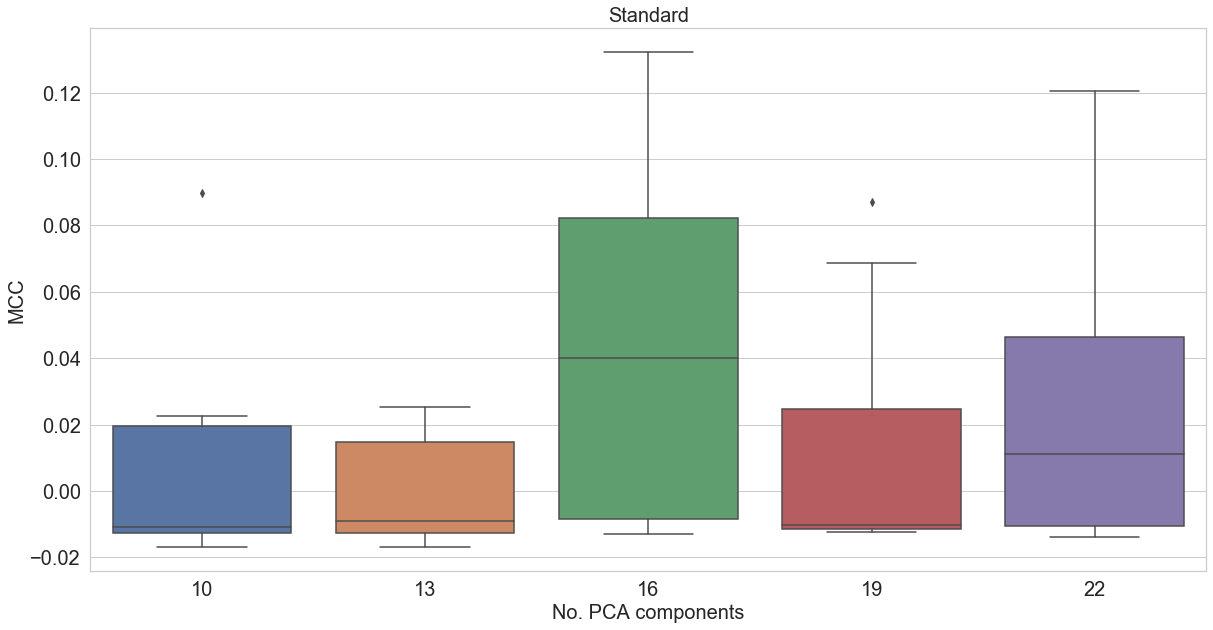

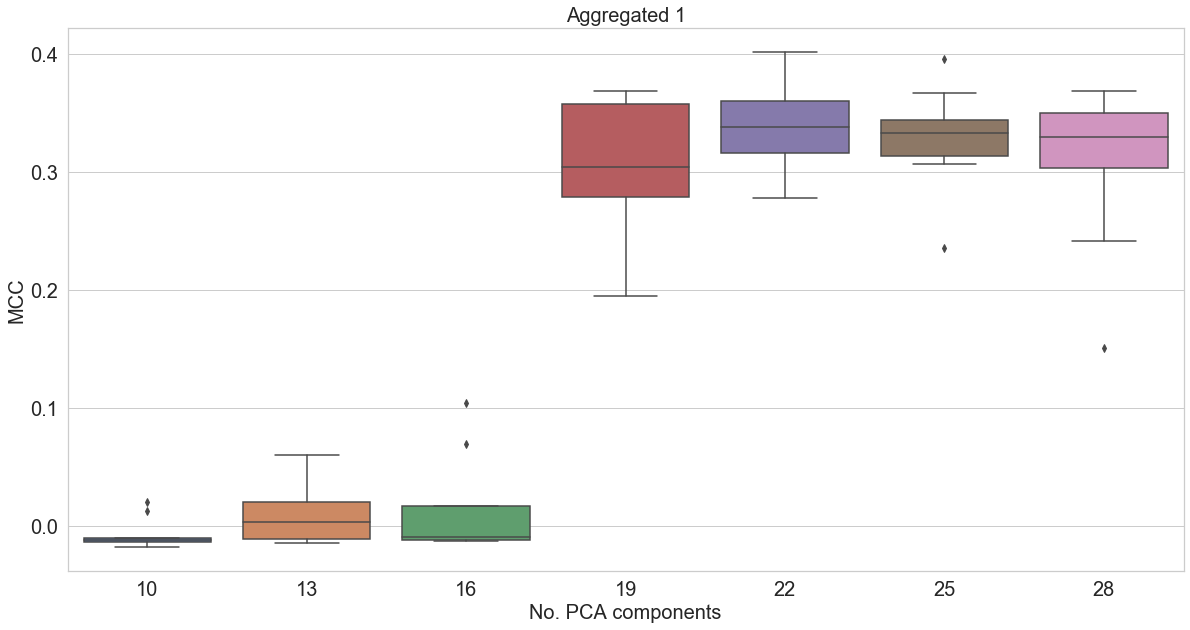

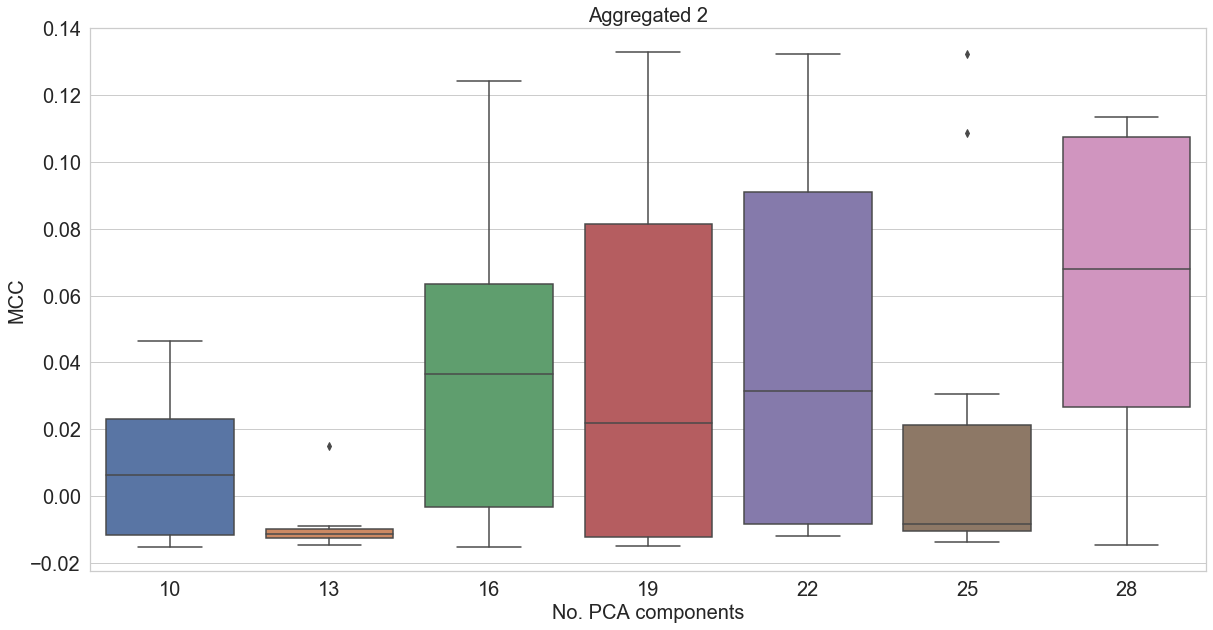

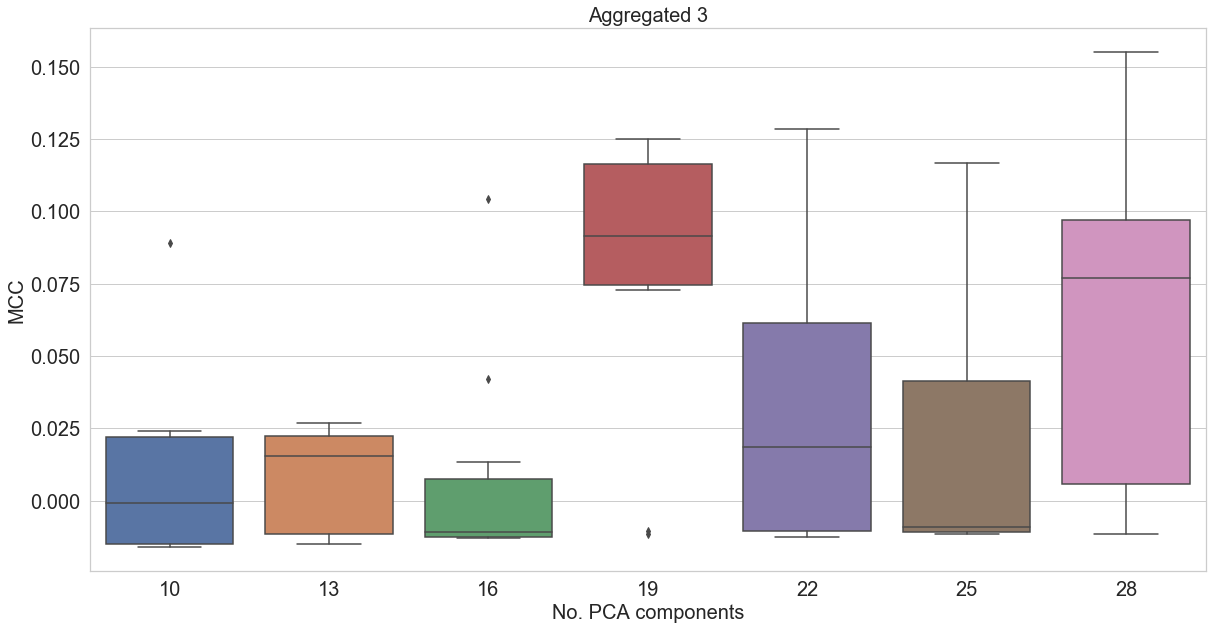

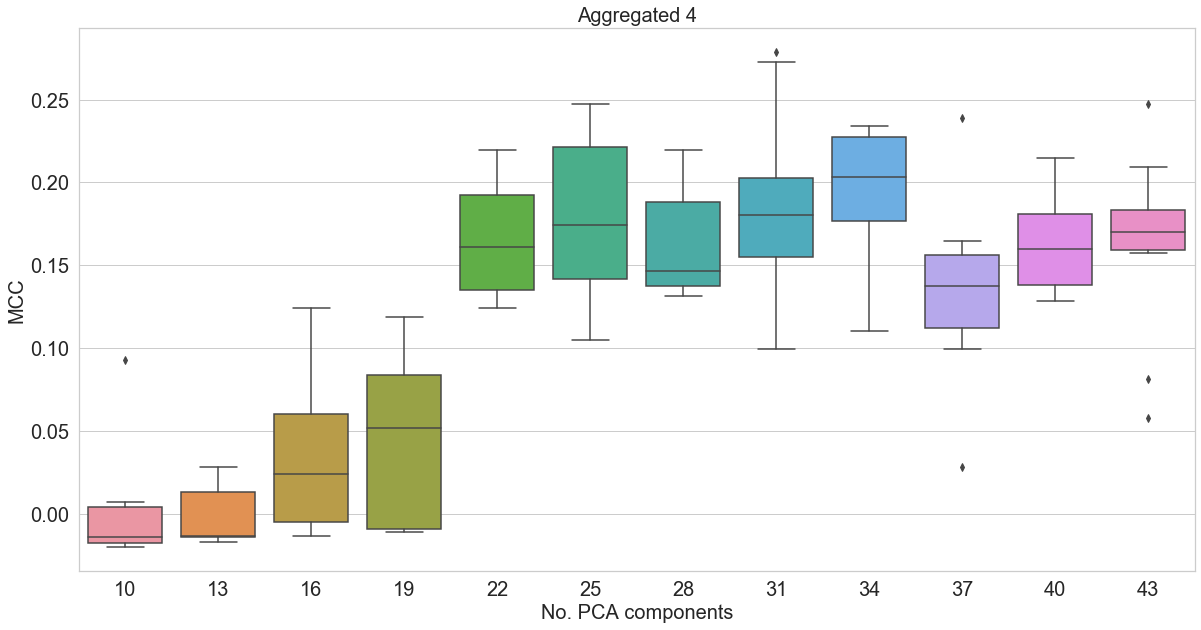

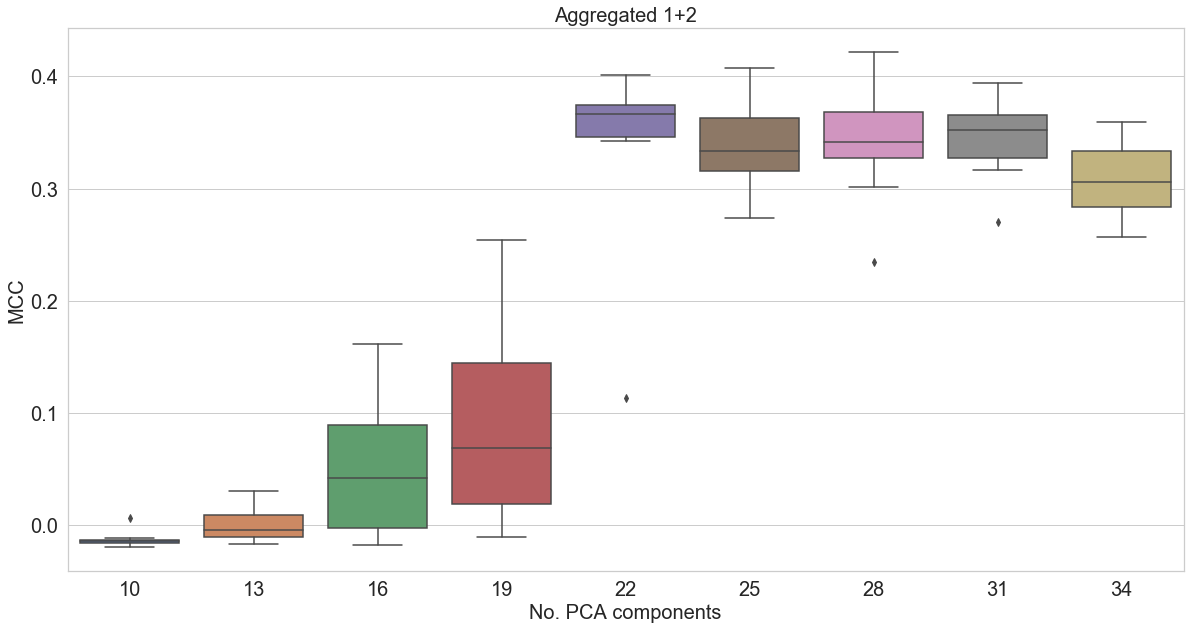

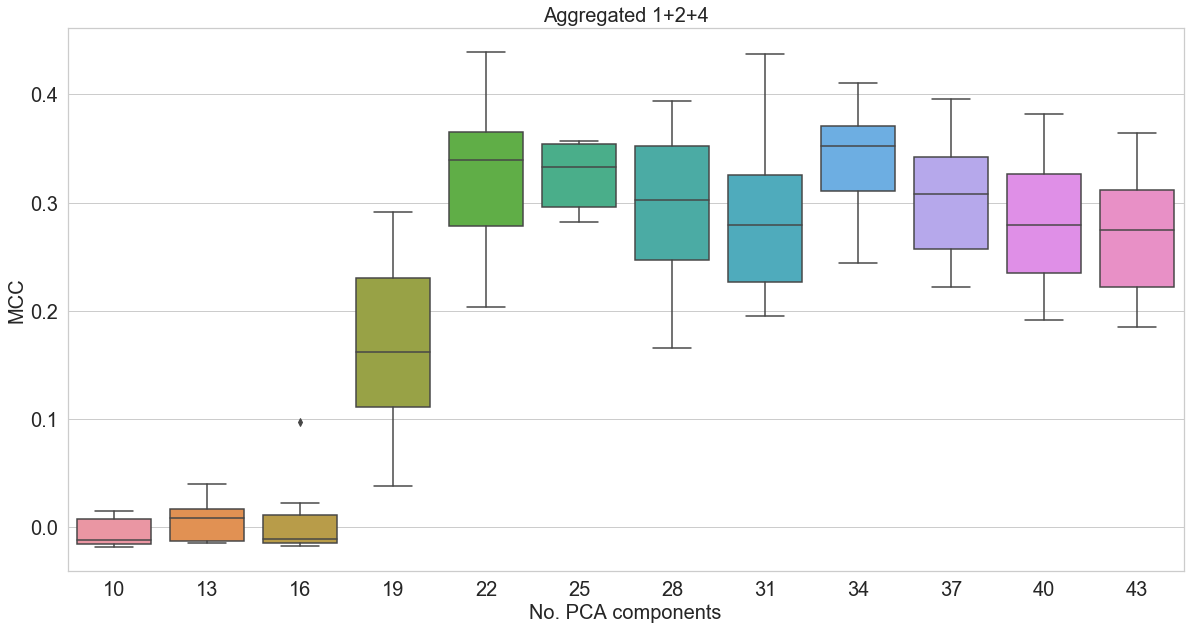

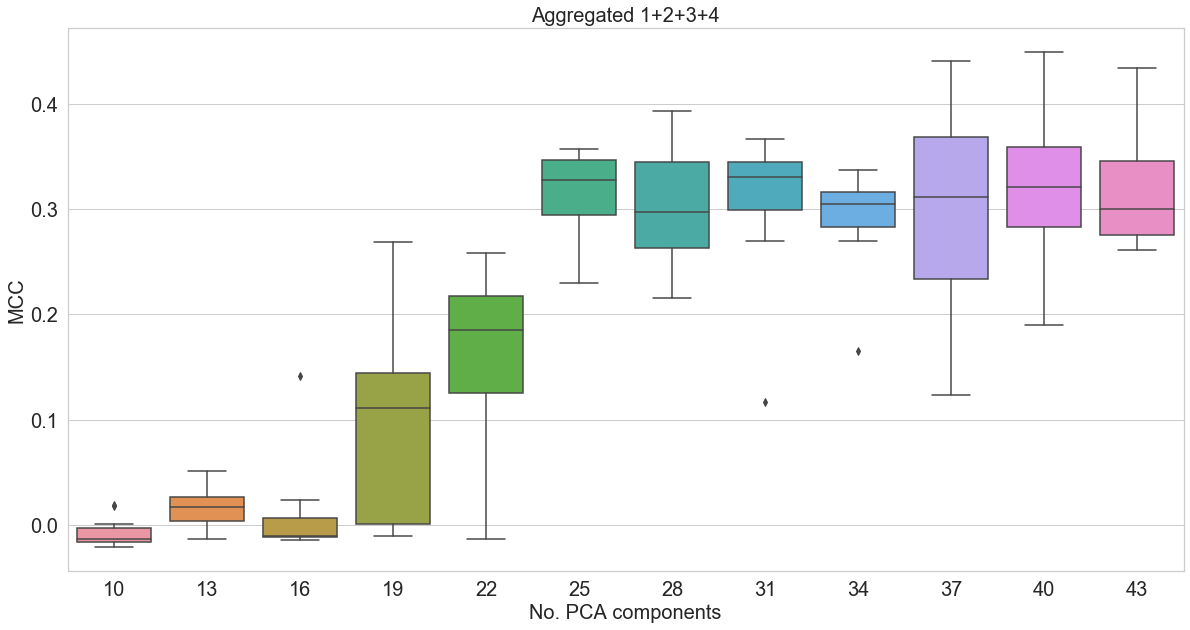

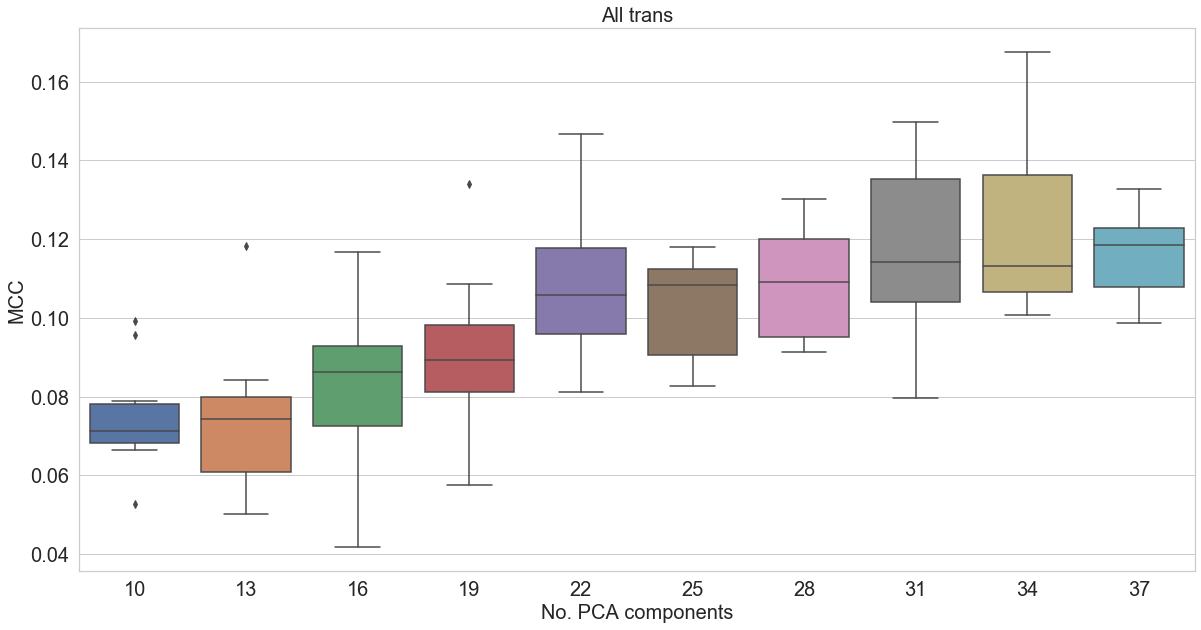

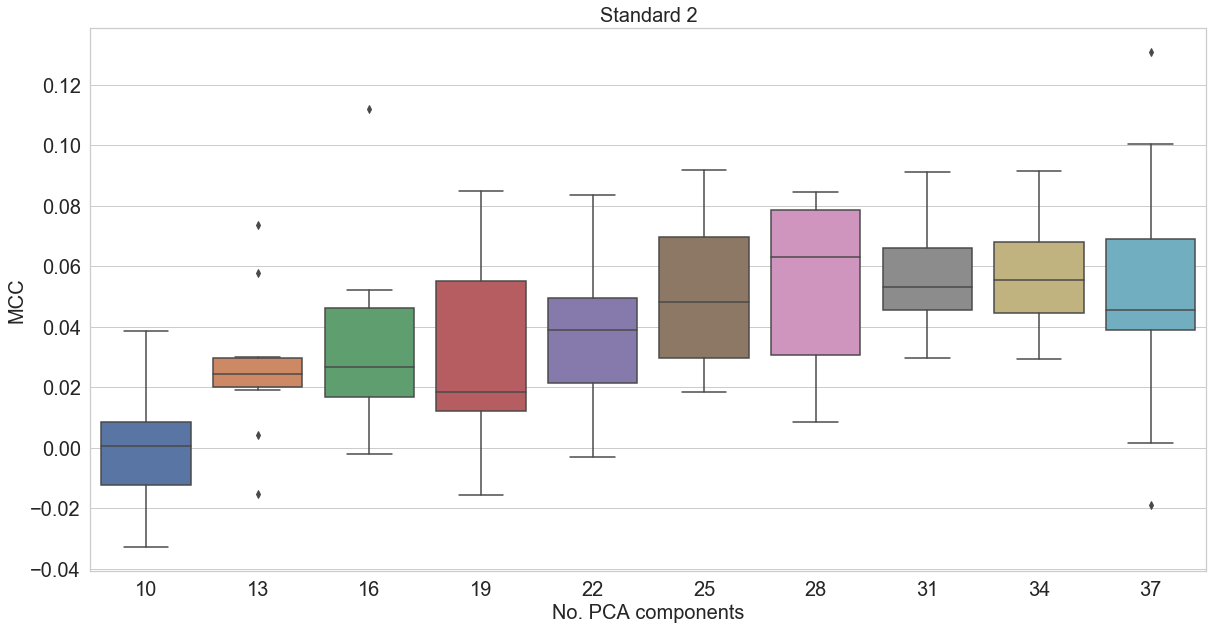

In [17]:
'Box plots for PCA reduction'
save_folder = 'Plots/Feature Reduction'
box_plot_4_dict(key2='PCA reduction',x_col='No. PCA components',folder=save_folder)


## Feature selection and PCA reduction

In [19]:
key ='Standard 2'
from sklearn.decomposition import PCA

min_features = 15
max_features = 20
jump = 5
pca_reduction_set = [-3,-6]#,-9,-12]
# for i in [1]:
for key in set_dict.keys():
    print(key)
    set_dict[key]['PCA n Features'] = {}
    set_dict[key]['PCA n Features']['Runs'] = {}
    set_dict[key]['PCA n Features']['Runs']['Scores'] = {}
    set_dict[key]['PCA n Features']['Runs']['All runs'] = {}
    
    feature_order = set_dict[key]['Features']['Importance Order']
    
    filename = set_dict[key]['filename']
    df = read_data(filename,folder)
    
    Y = df.pop('Class')    
    df.loc[:,df.dtypes == 'bool'] = df.loc[:,df.dtypes == 'bool'].astype(int)
    
    no_feats=list(range(min_features,min(max_features,df.shape[1]-1),jump))
    for i,n_features in enumerate(no_feats):
        print('{}/{}'.format(i+1,len(no_feats)))
        
        set_dict[key]['PCA n Features']['Runs']['Scores'][n_features] = {}
        set_dict[key]['PCA n Features']['Runs']['All runs'][n_features] = {}
        score_df = pd.DataFrame()
        for i,n_pca_reduction in enumerate(pca_reduction_set):
            print(n_pca_reduction)
            n_components = n_features + n_pca_reduction
        
            Xtrain,Xtest,Ytrain,Ytest = sets = train_test_split(df,Y.values,
                            train_size=0.5,
                            shuffle=False)

            Xtrain,scaler = scale_data(Xtrain,'MinMax')
            Xtest= scaler.transform(Xtest.values)

            pca = PCA(n_components= n_components)
            Xtrain = pca.fit_transform(Xtrain)
            Xtest  = pca.transform(Xtest)
        
            mets = 0
            
            temp = pd.DataFrame()
            for j in range(10):
                elm = ELM(m=128,w=10,type='wc') # 'standard 2'
                elm.fit(Xtrain,Ytrain)
                Ypreds = elm.predict(Xtest)
                met = getMetrics(Ytest,Ypreds)
                mets += met

                met.loc['Run'] = j+1
                temp = temp.append(met,ignore_index=True)
            temp.loc[:,'PCA reduction'] = n_pca_reduction
            score_df = score_df.append(temp,ignore_index=True)
            
            print(mets/(j+1))
            
            set_dict[key]['PCA n Features']['Runs']['Scores'][n_features][n_pca_reduction] = mets / (j+1)
            set_dict[key]['PCA n Features']['Runs']['All runs'][n_features][n_pca_reduction] = score_df

Standard
1/1
-3
Balanced Accuracy       0.505112
MCC                     0.016462
Accuracy                0.973255
F1-Score                0.025010
Precision               0.046926
Recall                  0.017391
True Negatives       2229.900000
False Positives        16.100000
False Negatives        45.200000
True Positives          0.800000
dtype: float64
-6
Balanced Accuracy       0.501090
MCC                     0.002214
Accuracy                0.969546
F1-Score                0.016307
Precision               0.021848
Recall                  0.013043
True Negatives       2221.600000
False Positives        24.400000
False Negatives        45.400000
True Positives          0.600000
dtype: float64
-9
Balanced Accuracy       0.496056
MCC                    -0.010893
Accuracy                0.970113
F1-Score                0.003030
Precision               0.005000
Recall                  0.002174
True Negatives       2223.400000
False Positives        22.600000
False Negatives        4

1/1
-3
Balanced Accuracy       0.502381
MCC                     0.003542
Accuracy                0.972077
F1-Score                0.015756
Precision               0.020279
Recall                  0.013043
True Negatives       2227.400000
False Positives        18.600000
False Negatives        45.400000
True Positives          0.600000
dtype: float64
-6
Balanced Accuracy       0.499888
MCC                    -0.001229
Accuracy                0.967190
F1-Score                0.014721
Precision               0.017131
Recall                  0.013043
True Negatives       2216.200000
False Positives        29.800000
False Negatives        45.400000
True Positives          0.600000
dtype: float64
-9
Balanced Accuracy       0.498556
MCC                    -0.003306
Accuracy                0.966667
F1-Score                0.012932
Precision               0.016174
Recall                  0.010870
True Negatives       2215.100000
False Positives        30.900000
False Negatives        45.500000


Now we'll study how a combination a subset of features and PCA-reduction affects the results.

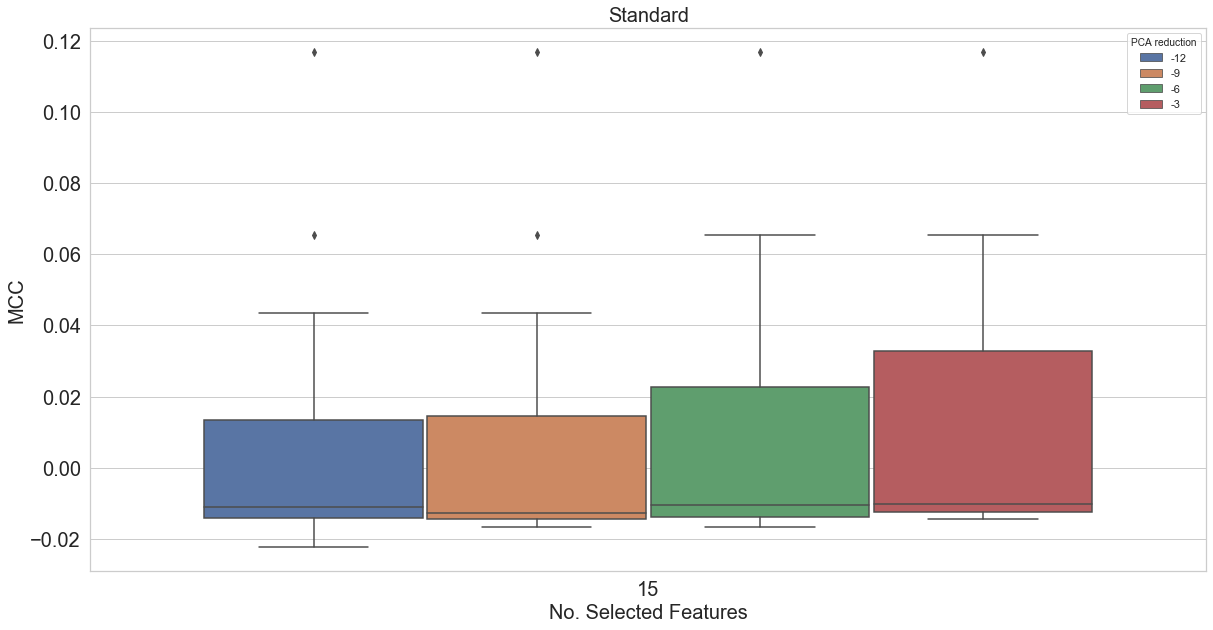

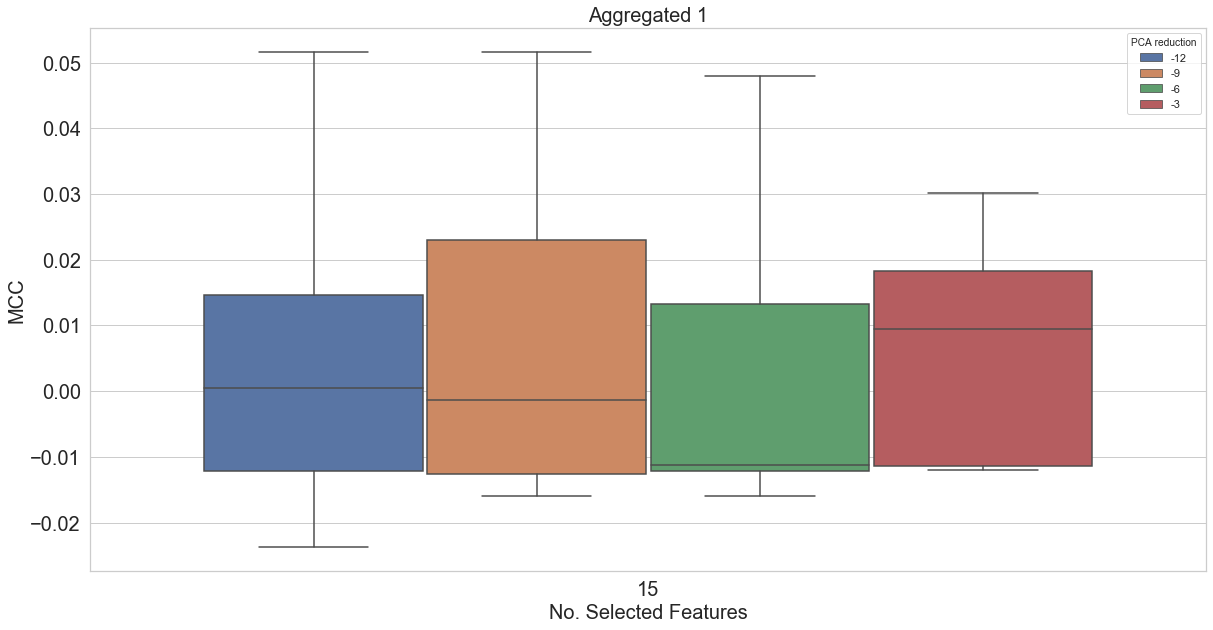

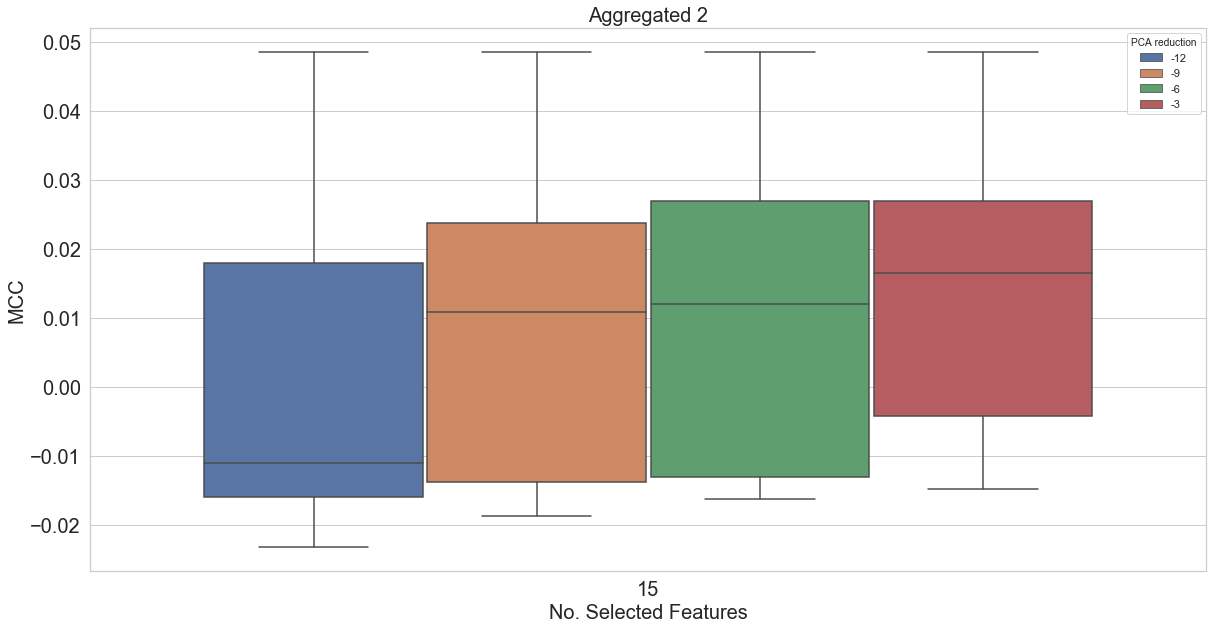

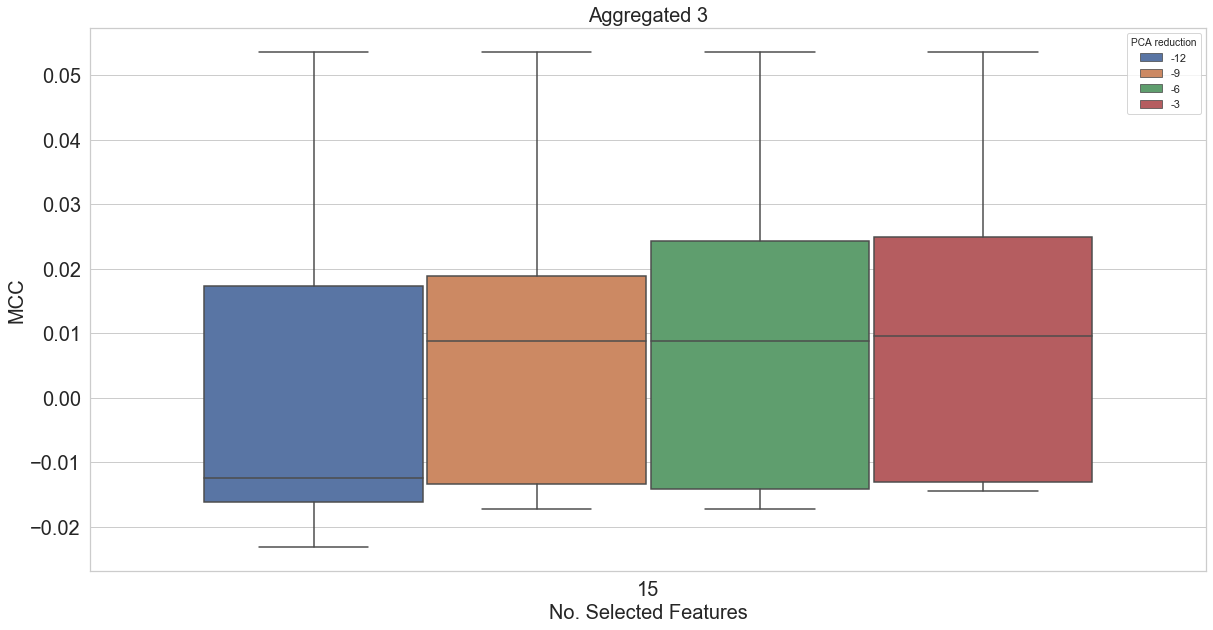

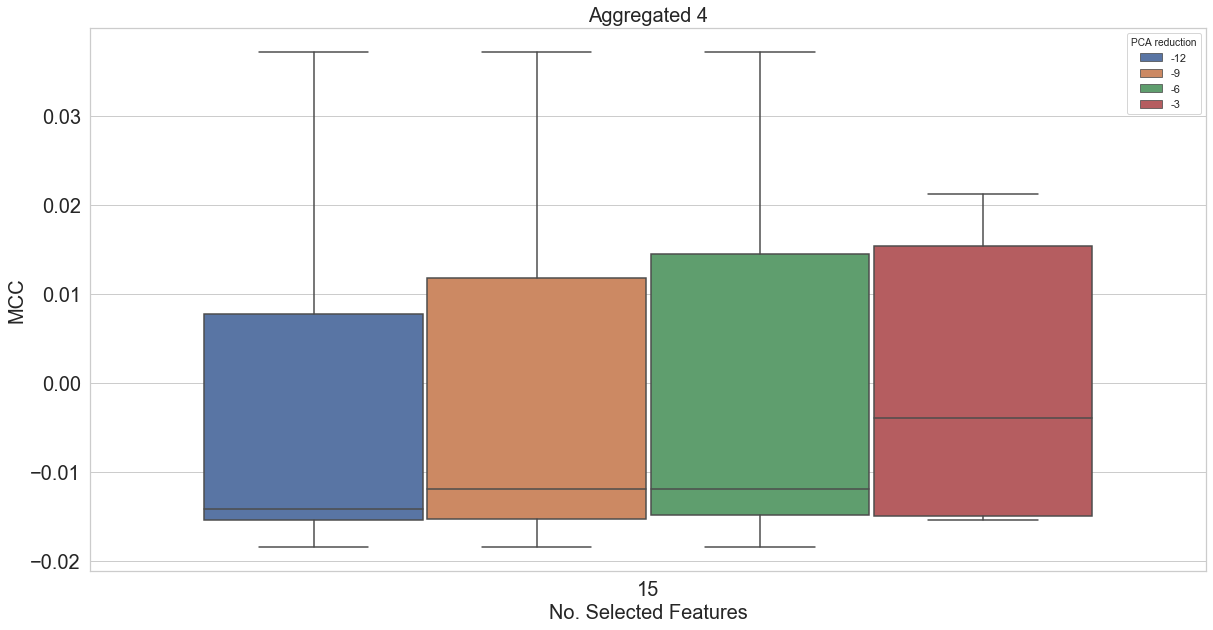

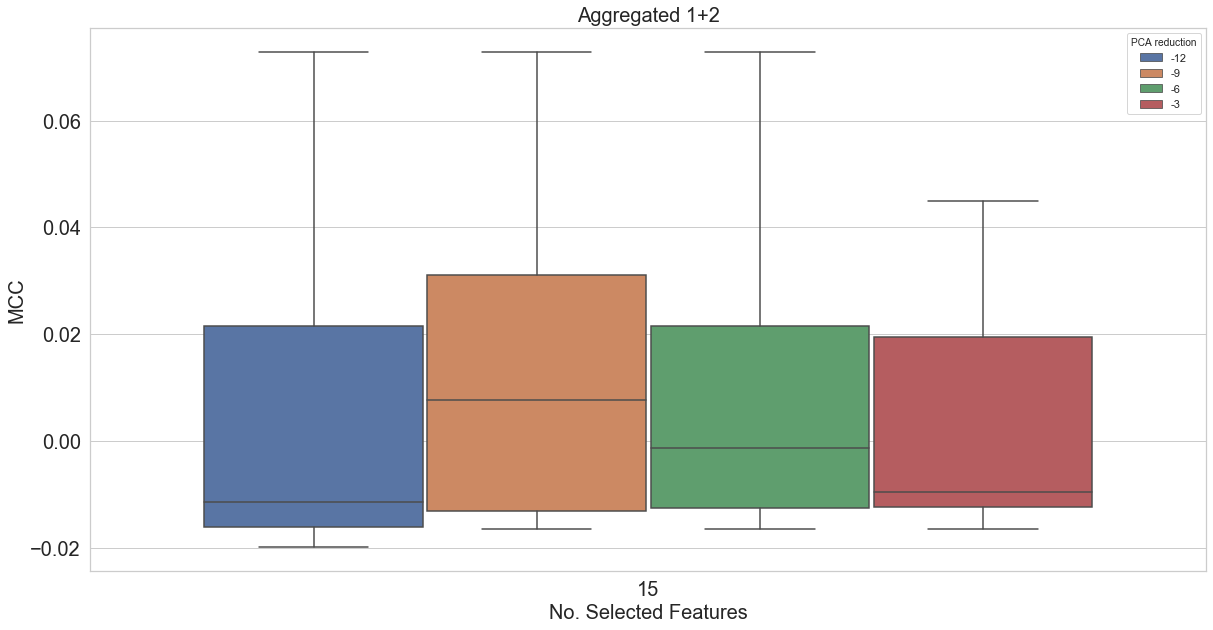

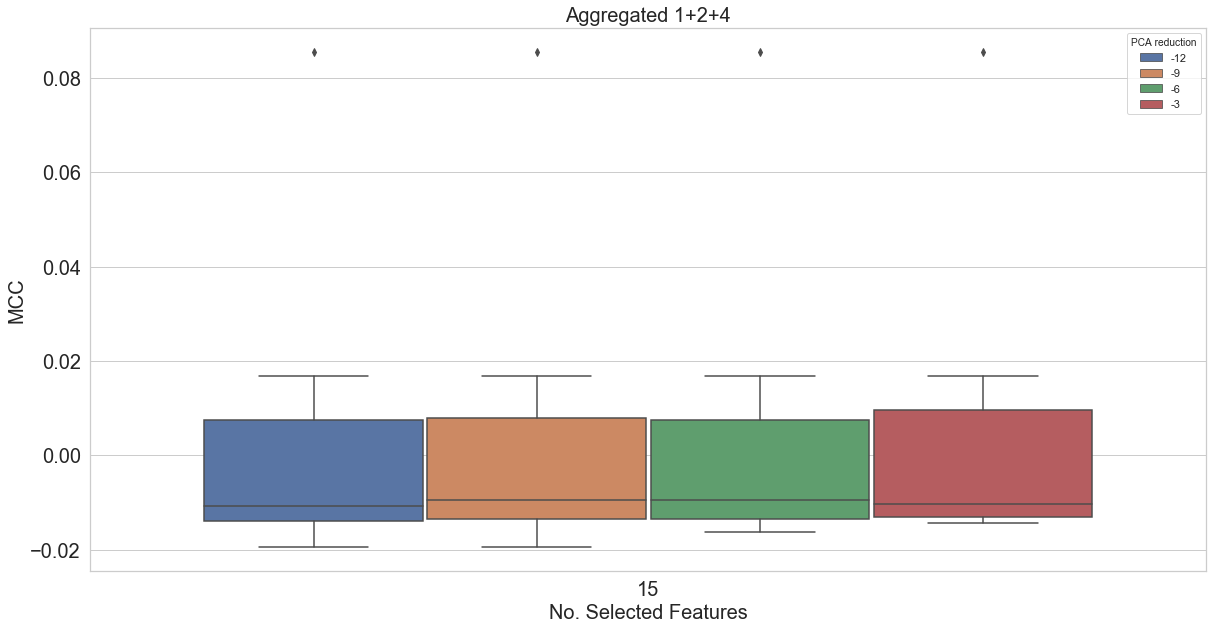

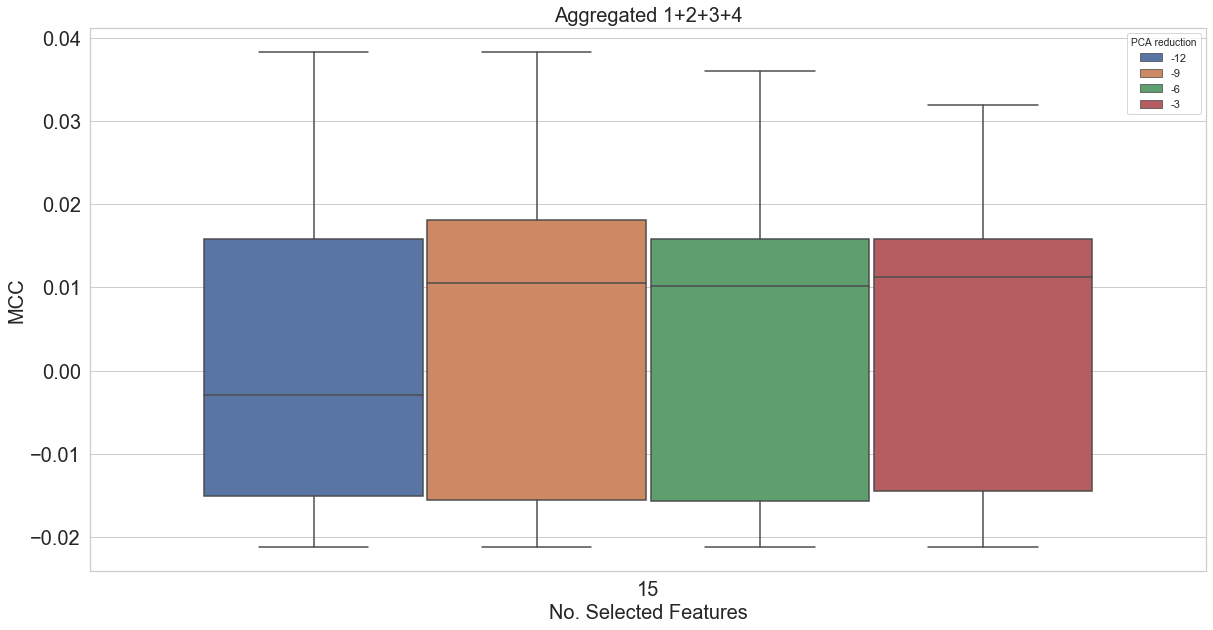

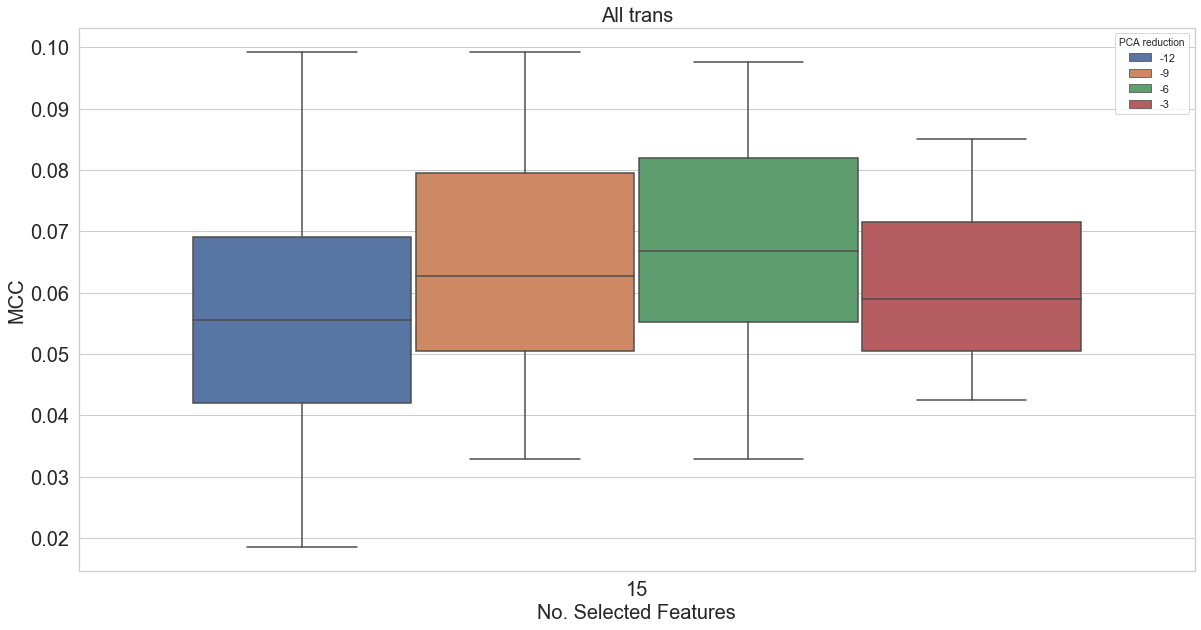

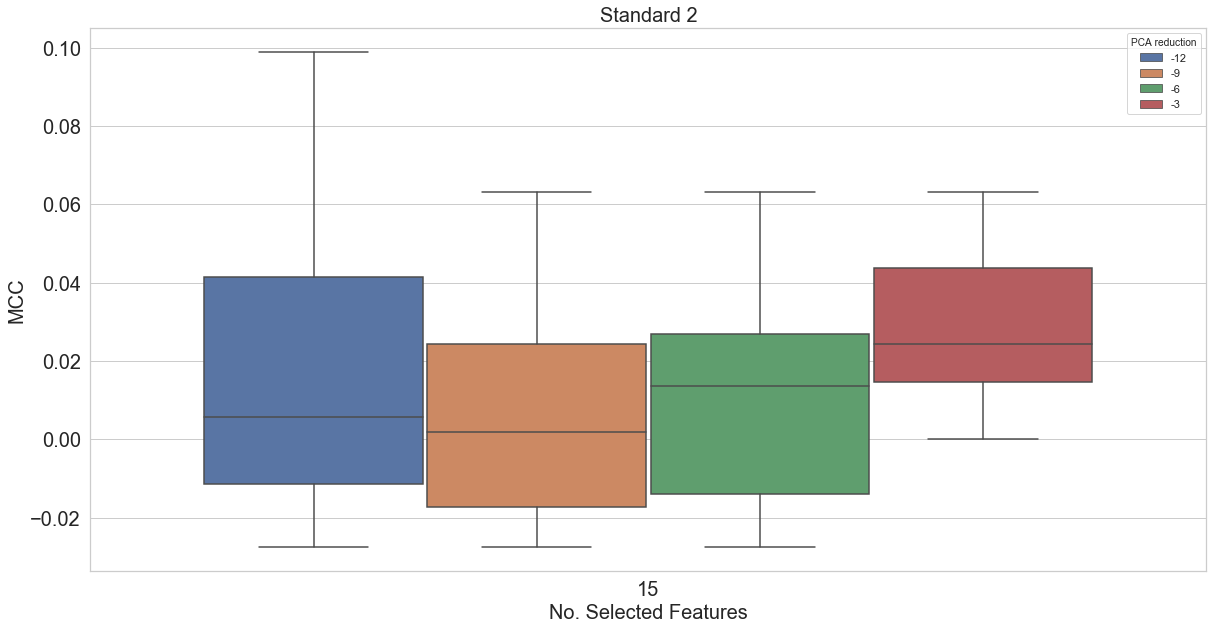

In [20]:
save_folder = 'Plots/Feature Reduction'
for key in set_dict.keys():
    bigg_df = pd.DataFrame()
    for i in set_dict[key]['PCA n Features']['Runs']['All runs'].keys():
        
        small_df = pd.DataFrame()
        for n_pca_reduction in set_dict[key]['PCA n Features']['Runs']['All runs'][i]:   
            temp_df =set_dict[key]['PCA n Features']['Runs']['All runs'][i][n_pca_reduction]
            temp_df.loc[:,'No. Features'] = i
            temp_df.loc[:,'PCA reduction'] = n_pca_reduction
            
            small_df = pd.concat([small_df,temp_df]).reset_index(drop=True)
        
        bigg_df =pd.concat([bigg_df,small_df]).reset_index(drop=True)        
    set_dict[key]['PCA n Features']['PCA n Features'] = bigg_df
#     plt.tight_layout();
    fig,ax= plot_boxchart(bigg_df,title=key,x='No. Features',xlabel='No. Selected Features',hue='PCA reduction');
    fig.savefig('{}/{}_feature_selection_PCA.png'.format(save_folder,key))
    plt.show()

Now we have seen that; Feature Selection, Featurue Extraction, and PCA reduction can in some constellation improve classification rate, i.e MCC. 


### Sampling

In [120]:
## Over samplers
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE 
from imblearn.over_sampling import SVMSMOTE
OverSamplers = {
    'SMOTE': SMOTE,
    'ROS': RandomOverSampler,
    'ADASYN':ADASYN,
    'Border SMOTE': BorderlineSMOTE,
    'SVM SMOTE':SVMSMOTE
}
## Under samplers
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import RandomUnderSampler 
UnderSamplers = {
    'Near Miss': NearMiss,
    'RUS': RandomUnderSampler
}



SAMPLERS = {
    'Over':{
        'samplers':OverSamplers,
        'strategies': [0.05,0.1,0.2,0.4,]
    },
    'Under':{
        'samplers':UnderSamplers,
        'strategies': [0.1,0.2,0.4,0.8]
    }
}

In [142]:
sampling_dict = {}
for OU in SAMPLERS.keys():
    for key in set_dict.keys():
        sampling_dict[key] = {}
        key2 = '{} Sampling'.format(OU)
        set_dict[key][key2] = {}
        set_dict[key][key2]['df'] = pd.DataFrame()
    
for OU in SAMPLERS.keys():
    OU_dict = SAMPLERS[OU] 
    key2 = '{} Sampling'.format(OU)
    for sampler in OU_dict['samplers']:
        
        for key in set_dict.keys():
            set_dict[key][key2][sampler] = {}
        
        for strategy in OU_dict['strategies']:
            print('{}-Sampler: {}, Strategy: {}'.format(OU,sampler,strategy))
            temp_dict = run_feature_experiment(sampling_dict.copy(),'key2', 
                                          min_features = 15,
                                          max_features = 30,
                                          jump = 5,
                                          scale = True,
                                          do_PCA = False, # Cannot combine feature subset with do_PCA..
                                          new_key = True,
                                          feature_subset = False, 
                                          SAMPLER_dict = {}
                                      ) 
            
            for key in temp_dict.keys():                
                set_dict[key][key2][sampler][strategy] = temp_dict[key]['key2']['Runs']['All runs']
            
#             for key22 in temp_dict.keys():            
#                 set_dict[key][key2]['Samplings'] = temp_dict[key][key2]

Over-Sampler: SMOTE, Strategy: 0.05
Standard
1/2
2/2
Aggregated 1
1/3
2/3
3/3
Aggregated 2
1/3
2/3
3/3
Aggregated 3
1/3
2/3
3/3
Aggregated 4
1/3
2/3
3/3
Aggregated 1+2
1/3
2/3
3/3
Aggregated 1+2+4
1/3
2/3
3/3
Aggregated 1+2+3+4
1/3
2/3
3/3
All trans
1/3
2/3
3/3
Standard 2
1/3
2/3
3/3
Over-Sampler: SMOTE, Strategy: 0.1
Standard
1/2
2/2
Aggregated 1
1/3
2/3
3/3
Aggregated 2
1/3
2/3
3/3
Aggregated 3
1/3
2/3
3/3
Aggregated 4
1/3
2/3
3/3
Aggregated 1+2
1/3
2/3
3/3
Aggregated 1+2+4
1/3
2/3
3/3
Aggregated 1+2+3+4
1/3
2/3
3/3
All trans
1/3
2/3
3/3
Standard 2
1/3
2/3
3/3
Over-Sampler: SMOTE, Strategy: 0.2
Standard
1/2
2/2
Aggregated 1
1/3
2/3
3/3
Aggregated 2
1/3
2/3
3/3
Aggregated 3
1/3
2/3
3/3
Aggregated 4
1/3
2/3
3/3
Aggregated 1+2
1/3
2/3
3/3
Aggregated 1+2+4
1/3
2/3
3/3
Aggregated 1+2+3+4
1/3
2/3
3/3
All trans
1/3
2/3
3/3
Standard 2
1/3
2/3
3/3
Over-Sampler: SMOTE, Strategy: 0.4
Standard
1/2
2/2
Aggregated 1
1/3
2/3
3/3
Aggregated 2
1/3
2/3
3/3
Aggregated 3
1/3
2/3
3/3
Aggregated 4
1/3
2/3

In [143]:
for OU in['Under','Over']:
    for key in temp_dict.keys():
            key2 = '{} Sampling'.format(OU)
            set_dict[key][key2]['df'] = pd.DataFrame()        
            for sampler in set_dict[key][key2].keys():
                for strategy in set_dict[key][key2][sampler].keys():
                    for n_feats in set_dict[key][key2][sampler][strategy]:
                            sampling_df = set_dict[key][key2][sampler][strategy][n_feats]
                            sampling_df.loc[:,'Sampler']      = sampler
                            sampling_df.loc[:,'Strategy']     = strategy
                            sampling_df.loc[:,'No. Features'] = n_feats

                            set_dict[key][key2]['df'] = set_dict[key][key2]['df'].append(sampling_df,ignore_index=True)



Standard Near Miss 0.1 15
Standard Near Miss 0.1 20
Standard Near Miss 0.2 15
Standard Near Miss 0.2 20
Standard Near Miss 0.4 15
Standard Near Miss 0.4 20
Standard Near Miss 0.8 15
Standard Near Miss 0.8 20
Standard RUS 0.1 15
Standard RUS 0.1 20
Standard RUS 0.2 15
Standard RUS 0.2 20
Standard RUS 0.4 15
Standard RUS 0.4 20
Standard RUS 0.8 15
Standard RUS 0.8 20
Aggregated 1 Near Miss 0.1 15
Aggregated 1 Near Miss 0.1 20
Aggregated 1 Near Miss 0.1 25
Aggregated 1 Near Miss 0.2 15
Aggregated 1 Near Miss 0.2 20
Aggregated 1 Near Miss 0.2 25
Aggregated 1 Near Miss 0.4 15
Aggregated 1 Near Miss 0.4 20
Aggregated 1 Near Miss 0.4 25
Aggregated 1 Near Miss 0.8 15
Aggregated 1 Near Miss 0.8 20
Aggregated 1 Near Miss 0.8 25
Aggregated 1 RUS 0.1 15
Aggregated 1 RUS 0.1 20
Aggregated 1 RUS 0.1 25
Aggregated 1 RUS 0.2 15
Aggregated 1 RUS 0.2 20
Aggregated 1 RUS 0.2 25
Aggregated 1 RUS 0.4 15
Aggregated 1 RUS 0.4 20
Aggregated 1 RUS 0.4 25
Aggregated 1 RUS 0.8 15
Aggregated 1 RUS 0.8 20
Aggregat

Aggregated 2 SMOTE 0.05 15
Aggregated 2 SMOTE 0.05 20
Aggregated 2 SMOTE 0.05 25
Aggregated 2 SMOTE 0.1 15
Aggregated 2 SMOTE 0.1 20
Aggregated 2 SMOTE 0.1 25
Aggregated 2 SMOTE 0.2 15
Aggregated 2 SMOTE 0.2 20
Aggregated 2 SMOTE 0.2 25
Aggregated 2 SMOTE 0.4 15
Aggregated 2 SMOTE 0.4 20
Aggregated 2 SMOTE 0.4 25
Aggregated 2 ROS 0.05 15
Aggregated 2 ROS 0.05 20
Aggregated 2 ROS 0.05 25
Aggregated 2 ROS 0.1 15
Aggregated 2 ROS 0.1 20
Aggregated 2 ROS 0.1 25
Aggregated 2 ROS 0.2 15
Aggregated 2 ROS 0.2 20
Aggregated 2 ROS 0.2 25
Aggregated 2 ROS 0.4 15
Aggregated 2 ROS 0.4 20
Aggregated 2 ROS 0.4 25
Aggregated 2 ADASYN 0.05 15
Aggregated 2 ADASYN 0.05 20
Aggregated 2 ADASYN 0.05 25
Aggregated 2 ADASYN 0.1 15
Aggregated 2 ADASYN 0.1 20
Aggregated 2 ADASYN 0.1 25
Aggregated 2 ADASYN 0.2 15
Aggregated 2 ADASYN 0.2 20
Aggregated 2 ADASYN 0.2 25
Aggregated 2 ADASYN 0.4 15
Aggregated 2 ADASYN 0.4 20
Aggregated 2 ADASYN 0.4 25
Aggregated 2 Border SMOTE 0.05 15
Aggregated 2 Border SMOTE 0.05 20

Aggregated 1+2+3+4 SMOTE 0.4 20
Aggregated 1+2+3+4 SMOTE 0.4 25
Aggregated 1+2+3+4 ROS 0.05 15
Aggregated 1+2+3+4 ROS 0.05 20
Aggregated 1+2+3+4 ROS 0.05 25
Aggregated 1+2+3+4 ROS 0.1 15
Aggregated 1+2+3+4 ROS 0.1 20
Aggregated 1+2+3+4 ROS 0.1 25
Aggregated 1+2+3+4 ROS 0.2 15
Aggregated 1+2+3+4 ROS 0.2 20
Aggregated 1+2+3+4 ROS 0.2 25
Aggregated 1+2+3+4 ROS 0.4 15
Aggregated 1+2+3+4 ROS 0.4 20
Aggregated 1+2+3+4 ROS 0.4 25
Aggregated 1+2+3+4 ADASYN 0.05 15
Aggregated 1+2+3+4 ADASYN 0.05 20
Aggregated 1+2+3+4 ADASYN 0.05 25
Aggregated 1+2+3+4 ADASYN 0.1 15
Aggregated 1+2+3+4 ADASYN 0.1 20
Aggregated 1+2+3+4 ADASYN 0.1 25
Aggregated 1+2+3+4 ADASYN 0.2 15
Aggregated 1+2+3+4 ADASYN 0.2 20
Aggregated 1+2+3+4 ADASYN 0.2 25
Aggregated 1+2+3+4 ADASYN 0.4 15
Aggregated 1+2+3+4 ADASYN 0.4 20
Aggregated 1+2+3+4 ADASYN 0.4 25
Aggregated 1+2+3+4 Border SMOTE 0.05 15
Aggregated 1+2+3+4 Border SMOTE 0.05 20
Aggregated 1+2+3+4 Border SMOTE 0.05 25
Aggregated 1+2+3+4 Border SMOTE 0.1 15
Aggregated 1+2+

In [186]:
def plot_sampling(OU ='Under',save=False,save_folder='Plots/Sampling',subset_top=0.9):
    for key in set_dict.keys():
            key2 = '{} Sampling'.format(OU)
            df = set_dict[key][key2]['df']
            g = sns.catplot(
                x = 'Strategy',
                y = 'MCC',
                hue='No. Features',
                col='Sampler',
                col_wrap=2,
                data=df,
                kind="box"
            )
            title = '{}: Dataset {}'.format(key2,key)
            g.fig.subplots_adjust(top=subset_top)
            g.fig.suptitle(title) 
            if save:
                filename = key +' '+key2
                plt.savefig('{}/{}.png'.format(save_folder,filename))
            plt.show()

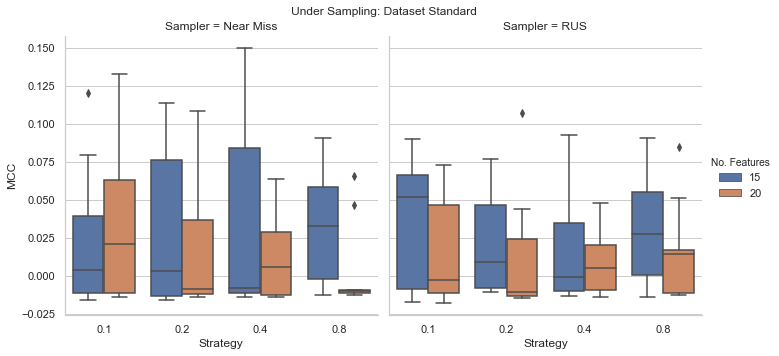

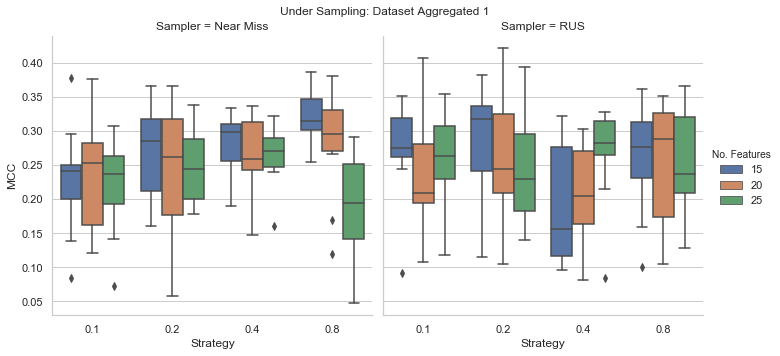

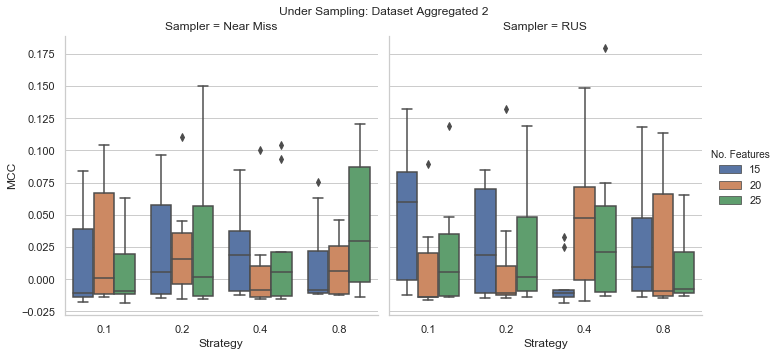

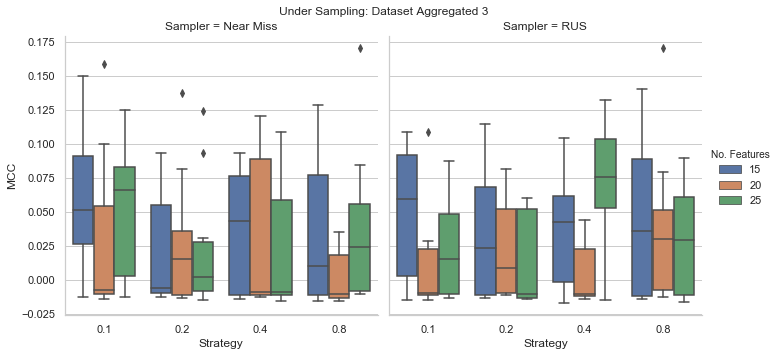

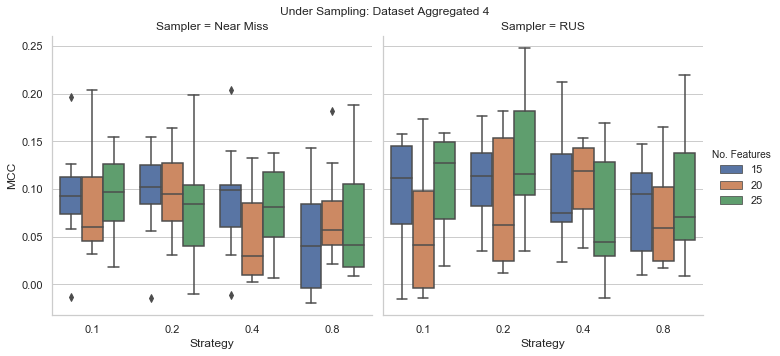

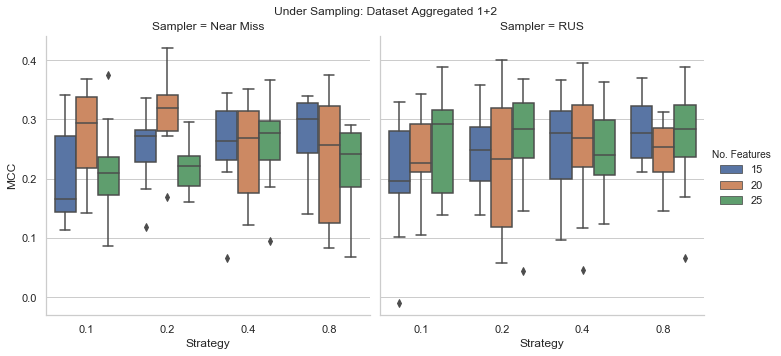

In [ ]:
OU = 'Under'
plot_sampling(OU,save=True,subset_top=0.9)

In [ ]:
OU = 'Over'
plot_sampling(OU,save=True,subset_top=0.95)